In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
import warnings
import seaborn as sns

In [2]:
# Remove when Theano is updated
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams["savefig.dpi"] = 150
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 16
plt.rcParams['font.sans-serif'] = ['Arial']

# Download the Data

In [4]:
kepler_ref = 2454833
villanovaEB_ref = 2400000 

In [5]:
KIC = 4544587
lit_period = 2.189094
lit_t0 = 2455462.006137 - 2454833 # Dan's version

Other measured parameters

In [6]:
# ******** from Villanova EB database ********
#lit_period = 2.1890973
#lit_t0 = 54954.135787 + villanova_tref-kepler_tref # Time of eclipse. Convention s.t. the primary (deeper) eclipse occurs at phase 0 (BJD-2400000)'
lit_R1 = 2.416
lit_R1_err = 0.6325
mu_R1 = np.log(lit_R1**2/np.sqrt((lit_R1**2 + lit_R1_err**2)))

pdepth = 0.4479 #in flux units
sdepth = 0.324  
pwidth = 2*0.1724  #in Phase units (it seems to be 1/2 the eclipse duration, so that's why we multiply it by 2)
swidth = 2*0.1292  

In [7]:
# ******** from https://arxiv.org/pdf/1306.1819.pdf ********
lit_R2 = 1.58  
lit_a = 10.855 #[Rsun]
lit_i = np.radians(87.9) #[degrees] 
lit_e = 0.275 
lit_omega = 5.74 #[rad]

Retrieve all the existing short-cadence photometry on this system. 

In [8]:
lcfs = lk.search_lightcurvefile("KIC %s"%KIC, mission="Kepler", cadence="short").download_all()
lc = lcfs.SAP_FLUX.stitch().remove_nans().remove_outliers(sigma = 3, sigma_lower = float('inf'))

/Users/mbadenas/opt/anaconda3/envs/mit37_mkl/lib/python3.7/site-packages/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)


Use a subset of the data (for now) 

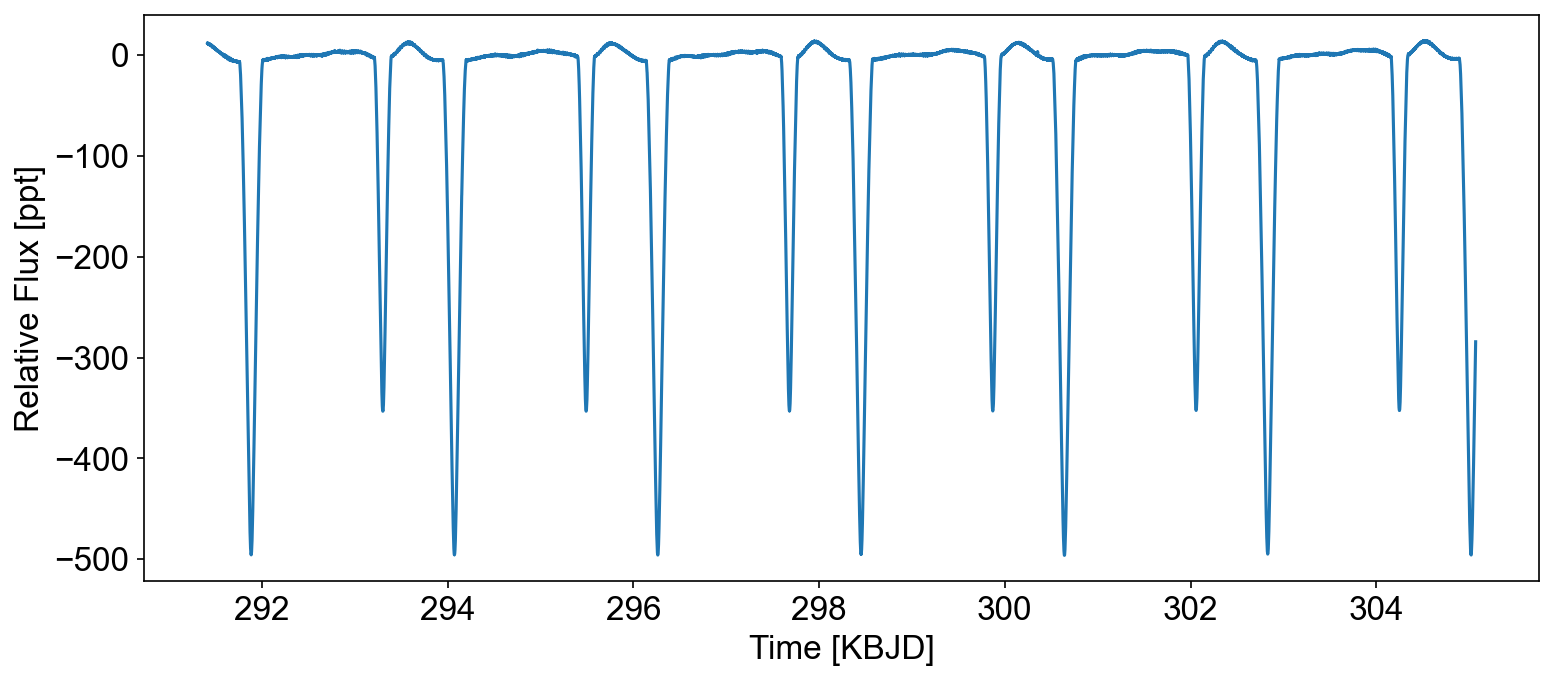

In [9]:
x = np.ascontiguousarray(lc.time[:20000], dtype=np.float64)
y = np.ascontiguousarray(lc.flux[:20000], dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err[:20000], dtype=np.float64)
mu = np.median(y)
y = (y / mu - 1) * 1e3

fig, ax = plt.subplots(1,1)
ax.plot(x,y) 
ax.set(xlabel = 'Time [KBJD]', ylabel = 'Relative Flux [ppt]');

Phase-fold the light curve

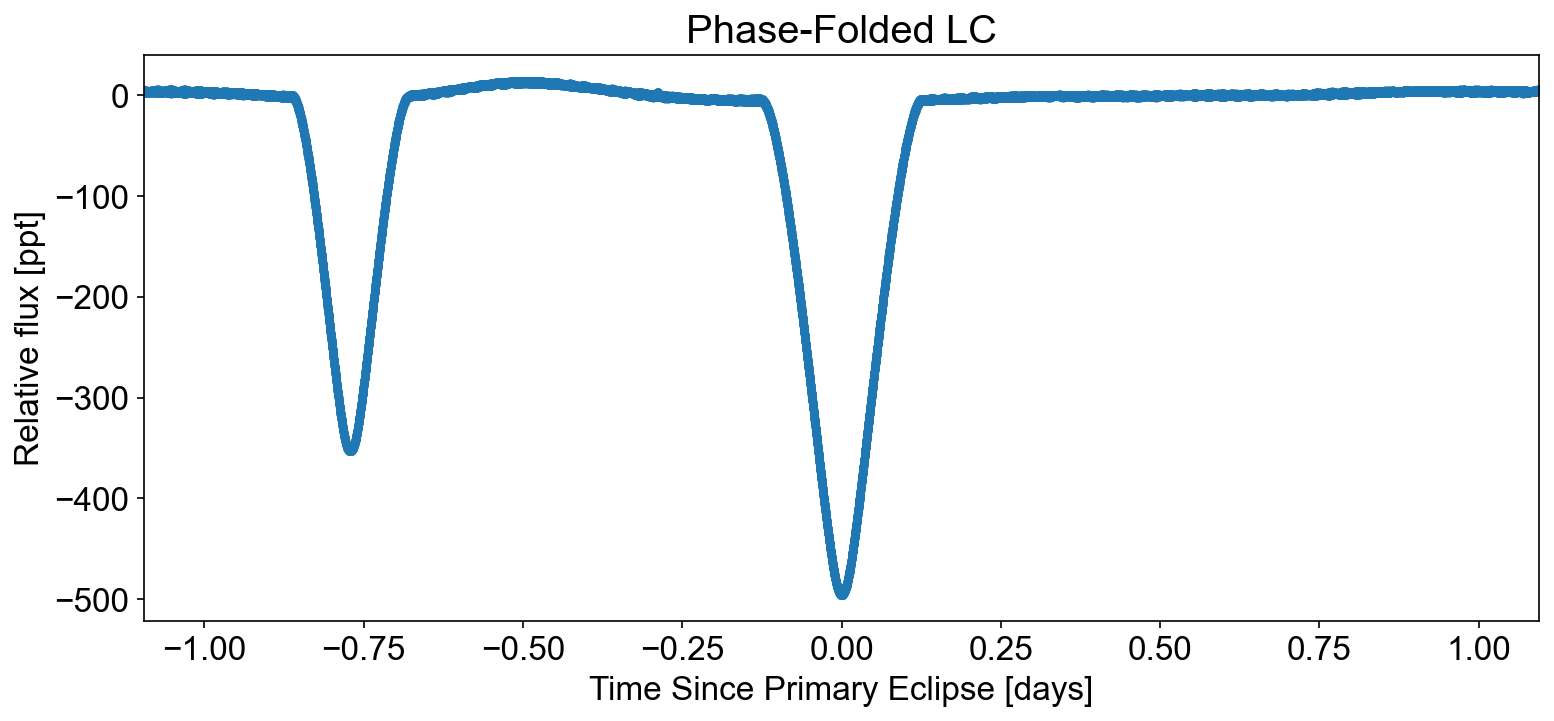

In [10]:
x_fold = (x - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period
    
fig, ax = plt.subplots(1,1)
ax.plot(x_fold, y, '.')
ax.set(
    xlim = (-0.5 * lit_period, 0.5 * lit_period), 
    xlabel = "Time Since Primary Eclipse [days]",
    ylabel = "Relative flux [ppt]",
    title = "Phase-Folded LC"
);

# Estimate the Phase Curve

In [11]:
bin_edges = lit_period * np.linspace(-0.5, 0.5, 5000)
num, _ = np.histogram(x_fold, bin_edges, weights=y)
denom, _ = np.histogram(x_fold, bin_edges)

In [12]:
x_smooth = 0.5 * (bin_edges[1:] + bin_edges[:-1])
y_smooth = num / denom
m = np.abs(x_smooth) > 0.5
second_phase = x_smooth[m][np.argmin(y_smooth[m])]

x_smooth = np.concatenate(([2 * x_smooth[0] - x_smooth[1]], x_smooth, [2 * x_smooth[-1] - x_smooth[-2]]))
y_smooth = np.concatenate(([y_smooth[-1]], y_smooth, [y_smooth[0]]))
mod = np.interp(x_fold, x_smooth, y_smooth) 

Compute the out-of-eclipse residuals from this phase curve

In [13]:
mask = (np.abs(x_fold - second_phase) > 0.2) & (np.abs(x_fold) > 0.2)
resid = y - mod
sigma = np.median(resid[mask] ** 2)
mask[mask] &= np.abs(resid[mask]) < 20 * sigma

Plot smoothed phase curve

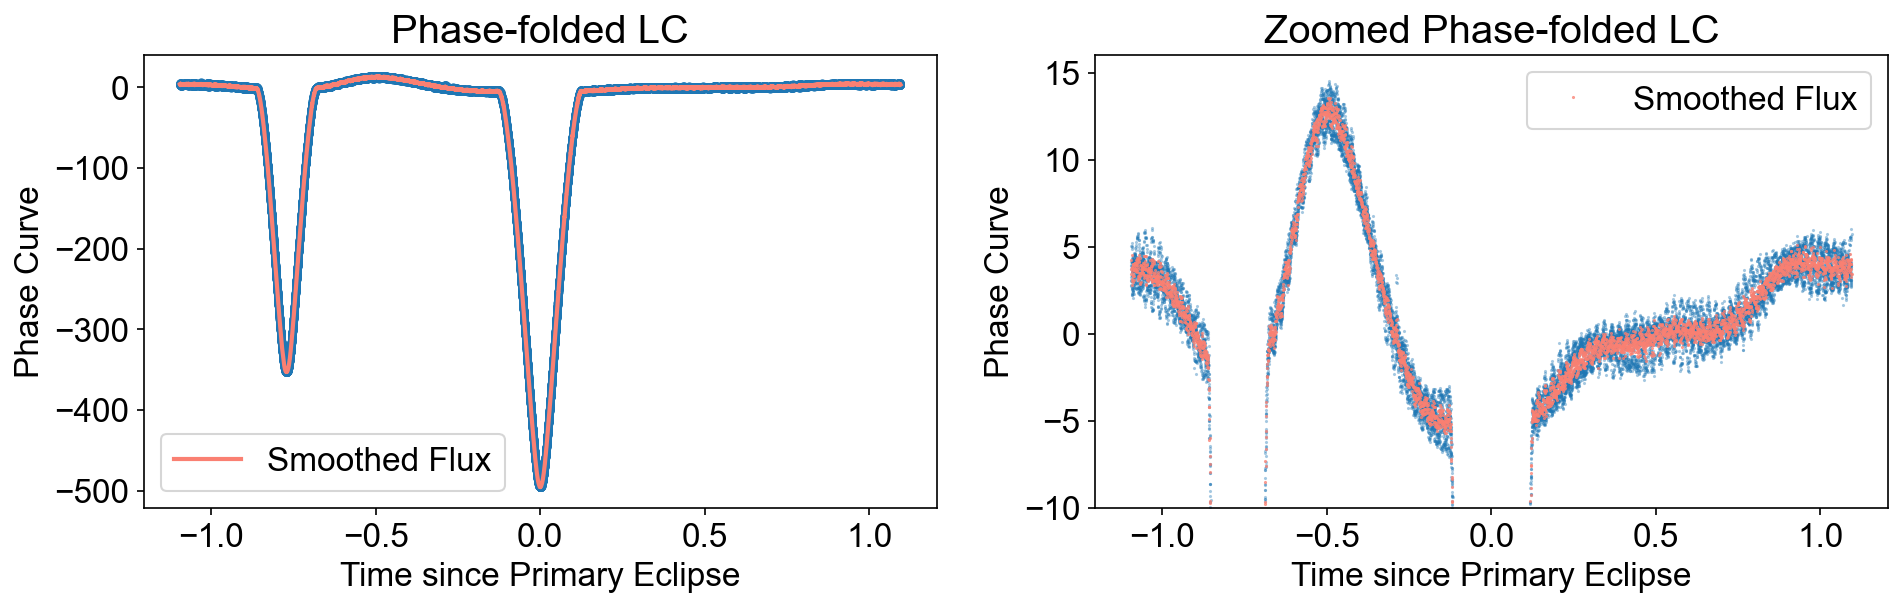

In [14]:
fig, ax = plt.subplots(1,2, sharex=True, figsize=(15,4))
fig.subplots_adjust(hspace=0.1)
ax[0].plot(x_fold,y, '.')
ax[0].plot(x_smooth, y_smooth, lw = 2, c = 'salmon', label = 'Smoothed Flux');
ax[0].legend()
ax[0].set(xlabel = "Time since Primary Eclipse", ylabel="Phase Curve", title = 'Phase-folded LC');
ax[1].plot(x_fold,y, '.', ms=1, alpha = 0.4)
ax[1].plot(x_smooth, y_smooth, '.', ms = 1, lw = 2, c = 'salmon', alpha = 0.8, label = 'Smoothed Flux');
ax[1].set(xlabel = "Time since Primary Eclipse", ylabel="Phase Curve", title = 'Zoomed Phase-folded LC', ylim=(-10,16));
ax[1].legend()

# Find 1st Batch of Oscillation Frequencies

In [15]:
def min2day(m): return m*6.944*(10**-4)
def hour2day(h): return h*0.04167

In [16]:
def freq2dhms(f): 
    if type(f) == int:
        d = 1./f
        print("f = %0.02f 1/d --> %0.04f days, %0.02f hours, %0.02f min, %0.02f sec" %(f, d, d*24, d*24.*60., d*24.*60.*60))
        
    else: 
        for freq in f:
            d = 1./freq
            print("f = %0.02f 1/d --> %0.04f days, %0.02f hours, %0.02f min, %0.02f sec" %(freq, d, d*24, d*24.*60., d*24.*60.*60))
        
def find_oscillations(time, flux, npeaks, minf, maxf, optional_it):
    res_ls = xo.estimators.lomb_scargle_estimator(
        time, 
        flux, 
        max_peaks=npeaks, 
        min_period=1.0/maxf, 
        max_period=1.0/minf
    )

    # Hack to remove nearby modes
    peak_freq = np.array([1.0/res_ls["peaks"][0]["period"]])
    peak_log_power = [res_ls["peaks"][0]["log_power"]]
    
    for peak in res_ls["peaks"][1:]:
        freq = 1.0 / peak["period"]
        if np.any(np.abs(peak_freq - freq) < 0.2):
            continue
        peak_freq = np.append(peak_freq, freq)
        peak_log_power.append(peak["log_power"])

    print(f"Found {len(peak_freq)} frequencies")
    
    freq2dhms(peak_freq)
    
    fig, ax = plt.subplots(1,1,figsize=(12,5))
    freq, power = res_ls["periodogram"]
    ax.plot(freq, power, color="grey")
    ax.plot(peak_freq, np.exp(peak_log_power), "or")
    ax.set(xlabel=r"Frequency [$d^{-1}$]", ylabel = "Power");
    plt.pause(0.05); plt.close("all")
    
    if optional_it is not None: fig.savefig('ls_periodogram_'+optional_it+".png")
    
    return res_ls, peak_freq, np.exp(peak_log_power)

Let's find the most dominant frequencies. We'll use them to initialize the model below. 

Found 10 frequencies
f = 48.03 1/d --> 0.0208 days, 0.50 hours, 29.98 min, 1798.85 sec
f = 41.37 1/d --> 0.0242 days, 0.58 hours, 34.81 min, 2088.62 sec
f = 46.21 1/d --> 0.0216 days, 0.52 hours, 31.16 min, 1869.76 sec
f = 47.12 1/d --> 0.0212 days, 0.51 hours, 30.56 min, 1833.65 sec
f = 39.55 1/d --> 0.0253 days, 0.61 hours, 36.41 min, 2184.40 sec
f = 44.85 1/d --> 0.0223 days, 0.54 hours, 32.11 min, 1926.37 sec
f = 47.59 1/d --> 0.0210 days, 0.50 hours, 30.26 min, 1815.42 sec
f = 40.46 1/d --> 0.0247 days, 0.59 hours, 35.59 min, 2135.30 sec
f = 38.22 1/d --> 0.0262 days, 0.63 hours, 37.68 min, 2260.68 sec
f = 49.40 1/d --> 0.0202 days, 0.49 hours, 29.15 min, 1748.96 sec


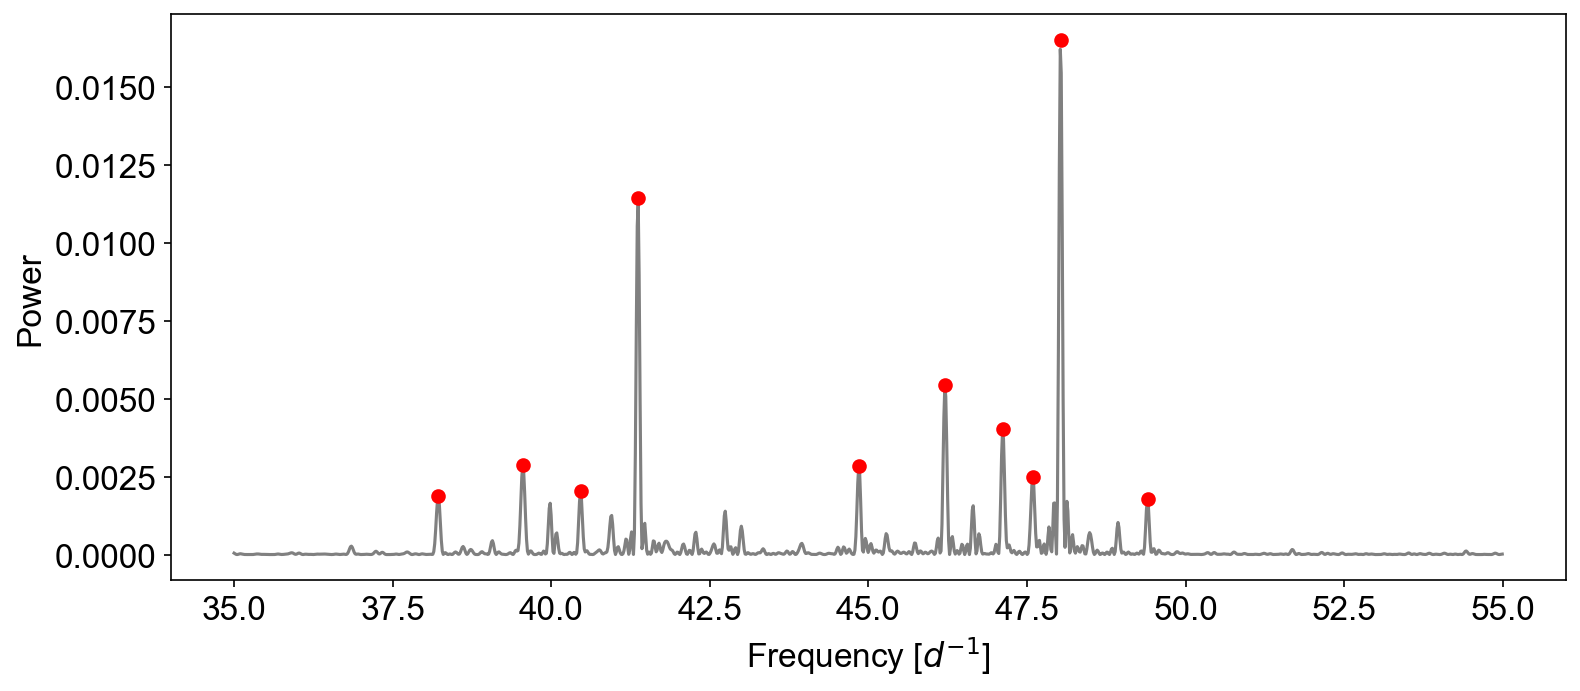

In [17]:
_, freq_osc_0, power_osc_0 = find_oscillations(x[mask], resid[mask], 10, 35, 55, None)

# Define the Model 

In [18]:
def build_model(time, flux, map_pr, mask, osc_freqs):
    with pm.Model() as model:
        
        # Systemic parameters
        u1 = xo.QuadLimbDark("u1")
        u2 = xo.QuadLimbDark("u2")

        # Parameters describing the primary: could include priors based on isochrones or similar
        M1 = pm.Lognormal("M1", mu=0.0, sigma=10.0)
        R1 = pm.Lognormal("R1", mu=0.0, sigma=10.0) 

        # Secondary ratios
        k = pm.Lognormal("k", mu=0.0, sigma=10.0)  # radius ratio R2/R1
        q = pm.Lognormal("q", mu=0.810, sigma=0.01)  # mass ratio M2/M1
        s = pm.Lognormal("s", mu=np.log(0.5), sigma=10.0)  # surface brightness ratio S2/S1

        # Parameters describing the orbit
        b = xo.ImpactParameter("b", ror=k, testval=1.5)
        period = pm.Lognormal("period", mu=np.log(lit_period), sigma=1.0)
        t0 = pm.Normal("t0", mu=lit_t0, sigma=1.0)

        # Parameters describing the eccentricity: ecs = [e * cos(w), e * sin(w)]
        ecosw = 0.25 * np.pi * (2 * (second_phase + lit_period) / lit_period - 1)
        ecs = xo.UnitDisk("ecs", testval=np.array([ecosw, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sqrt(tt.sum(ecs ** 2)))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # Build the orbit
        R2 = pm.Deterministic("R2", k * R1)
        M2 = pm.Deterministic("M2", q * M1)
        orbit = xo.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            ecc=ecc,
            omega=omega,
            b=b,
            r_star=R1,
            m_star=M1,
            m_planet=M2,
        )

        # Track some other orbital elements
        pm.Deterministic("incl", orbit.incl)
        pm.Deterministic("a", orbit.a)
        
        # Set up the light curve model
        lc = xo.SecondaryEclipseLightCurve(u1, u2, s)
        model_lc = 1e3 * lc.get_light_curve(orbit=orbit, r=R2, t=time[mask])[:, 0]

        # Oscillation model using frequencies from periodogram
        arg = osc_freqs[None, :] * time[mask, None]
        X = np.concatenate([np.cos(2 * np.pi * arg), np.sin(2 * np.pi * arg),], axis=1)
        
#         w0 = np.linalg.lstsq(X, y[mask])[0]
#         w = pm.Normal("w", mu=0.0, sigma=10.0, shape=len(w0), testval=w0)
#         osc = tt.dot(X, w)
#         osc = tt.zeros(mask.sum())
        
        # Phase curve: mixture of harmonics of the period. 6th order seems to work well based on trial and error
        phi = ((time[mask] - t0) / period) % 1.0
        n_expand = 6
        comps = tt.stack([
            tt.sin(2 * (n + 1) * np.pi * phi)
            for n in range(n_expand)
        ] + [
            tt.cos(2 * (n + 1) * np.pi * phi)
            for n in range(n_expand)
        ], axis=1)
#        amps = pm.Normal("amps", sigma=100.0, shape=2 * n_expand)
#        phase_curve = tt.dot(amps, comps)
        
        # # Transit jitter & GP parameters
        print(map_pr['sigma_lc'], map_pr['S_tot_lc'], map_pr['ell_lc'])
        sigma_lc = pm.InverseGamma("sigma_lc", testval = map_pr['sigma_lc'], **xo.estimate_inverse_gamma_parameters(0.1, 2.0))
        S_tot_lc = pm.InverseGamma("S_tot_lc", testval = map_pr['S_tot_lc'], **xo.estimate_inverse_gamma_parameters(1.0, 5.0))
        ell_lc = pm.InverseGamma("ell_lc", testval = map_pr['ell_lc'], **xo.estimate_inverse_gamma_parameters(1.0, 5.0))
        kernel_lc = xo.gp.terms.SHOTerm(S_tot=S_tot_lc, w0=2 * np.pi / ell_lc, Q=1.0/3) 
        gp_lc = xo.gp.GP(kernel_lc, time[mask], tt.zeros(mask.sum())** 2 + sigma_lc**2)
        
#       def mean_model(t):
#           return mean_lc + osc + phase_curve + model_lc(t)
        
        D = tt.concatenate((X, comps, tt.ones((mask.sum(), 1))), axis=1)
        DT = D.T
        DTD = tt.dot(DT, gp_lc.apply_inverse(DT.T)) + 0.01**2 * tt.eye(2 * (len(osc_freqs) + n_expand) + 1)
        
        DTD_det_print = tt.printing.Print("DTD_det")(tt.nlinalg.det(DTD))
        
        DTy = tt.dot(DT, gp_lc.apply_inverse((flux[mask] - model_lc)[:, None]))
        factor = tt.slinalg.cholesky(DTD)
        weights = tt.slinalg.solve_upper_triangular(factor.T, tt.slinalg.solve_lower_triangular(factor, DTy))[:, 0]
        #weights = tt.slinalg.solve(DTD, DTy)[:, 0]
        w = pm.Deterministic("w", weights[:2 * len(osc_freqs)])
        
        osc = tt.dot(X, w)
        amps = pm.Deterministic("amps", weights[2 * len(osc_freqs):2 * n_expand + 2 *len(osc_freqs)])
        phase_curve = tt.dot(comps, amps)
        mean_lc = pm.Deterministic("mean_lc", weights[-1]) 
        
#       # Condition the light curve model on the data
#         gp_lc = xo.gp.GP(
#             kernel_lc, x[mask], tt.zeros(mask.sum()) ** 2 + sigma_lc ** 2, mean=mean_model
#         )
        
        gp_lc.marginal("obs_lc", observed=flux[mask] - tt.dot(D, weights) - model_lc)
        pm.Deterministic("gp_pred", gp_lc.predict())

        # Optimize the logp to obtain the maximum a posteriori parameters
        map_soln = model.test_point
        map_soln = xo.optimize(map_soln, vars=[R1, k, s, b, u1, u2])
        #map_soln = xo.optimize(map_soln, [amps])
        #map_soln = xo.optimize(map_soln, [w])
        map_soln = xo.optimize(map_soln, vars=[S_tot_lc, ell_lc,sigma_lc])
        map_soln = xo.optimize(map_soln) 

        model.osc = osc
        model.phase_curve = phase_curve
        model.gp_lc = gp_lc
        model.model_lc = model_lc
        model.x = time[mask]
        model.y = flux[mask]

    return model, map_soln

In [19]:
cdict = {"lc": 'dodgerblue', "gp_pred": "orange", "pc": "green", "osc": "crimson"}
args = dict(lw=2)
    
def evaluate_model(flux, best_model, map_solution, i,plot_bool):
    
    with best_model:
        gp_pred = xo.eval_in_model(best_model.gp_lc.predict(), map_solution) + map_solution["mean_lc"]
        lc = xo.eval_in_model(best_model.model_lc, map_solution)
        osc, pc = xo.eval_in_model([best_model.osc, best_model.phase_curve], map_solution)
        
    model_residuals = flux - lc - pc - osc - gp_pred
    
    if plot_bool == True:
        fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12, 12))
        fig.subplots_adjust(hspace=0.1)

        ax1.plot(best_model.x, best_model.y, "k.", alpha=0.2, label = 'Observed LC')
        ax1.plot(best_model.x, lc, c=cdict["lc"], **args, label = 'Eclipse Model')
        ax1.plot(best_model.x, gp_pred, c=cdict["gp_pred"], **args, label = 'GP Model')
        ax1.legend(fontsize=12)
        ax1.set(ylabel="Raw flux [ppt]", title = "MAP model");

        ax2.plot(best_model.x, best_model.y, "k.", alpha=0.2, label = 'Observed LC')
        ax2.plot(best_model.x, osc, c=cdict["osc"], **args, label = 'Oscillations Model')
        ax2.plot(best_model.x, pc, c=cdict["pc"], **args, label = 'Phase Curve Model')
        ax2.legend(fontsize=12)
        ax2.set(xlim = (best_model.x.min(), best_model.x.max()), ylim = (-10, 15), ylabel="Raw flux [ppt]");

        ax3.plot(best_model.x, best_model.y - lc - pc - gp_pred, "k.", alpha=0.2, 
                 label = 'Observed LC - (Eclipse Model + PC Model + GP. Model)') #
        ax3.plot(best_model.x, osc, c=cdict["osc"], lw=1, label = "Oscillations Model")
        ax3.legend(fontsize=12)
        ax3.set(ylabel="Raw Flux [ppt]", xlabel = "Time [KBJD]");
        fig.savefig("map_model_"+i+".png")
        
        #Detrended Flux: Observed LC - (GP + Osc)
        fig, ax1 = plt.subplots(1, figsize=(12, 3.5))
        x_fold = (best_model.x - map_solution["t0"]) % map_solution["period"] / map_solution["period"]
        inds = np.argsort(x_fold)

        ax1.plot(x_fold[inds], best_model.y[inds] - gp_pred[inds] - osc[inds], "k.", alpha=0.2)
        ax1.plot(x_fold[inds] - 1, best_model.y[inds] - gp_pred[inds] - osc[inds], "k.", alpha=0.2)
        ax1.plot(x_fold[inds], lc[inds], c = cdict["lc"], **args, label = "Eclipse Model")
        ax1.plot(x_fold[inds] - 1, lc[inds], c = cdict["lc"], **args)
        ax1.plot(x_fold[inds], pc[inds], c = cdict["pc"], **args)
        ax1.plot(x_fold[inds] - 1, pc[inds],c = cdict["pc"], **args, label = "Phase Curve Model")
        ax1.set(xlim=(-1, 1), ylabel = "De-trended flux [ppt]", xlabel = "Phase", title = "MAP model");
        ax1.legend(fontsize=12)
        fig.tight_layout()
        fig.savefig("detrended_fux_"+i+".png")

        fig, (ax1,ax2) = plt.subplots(2,1, sharex = True, figsize=(16,10))
        ax1.plot(best_model.x, gp_pred, c=cdict["gp_pred"], label = 'GP Model')
        ax1.plot(best_model.x, pc, c=cdict["pc"], label = 'Phase Curve Model')
        ax1.plot(best_model.x, osc, c=cdict["osc"], label = 'Oscillation Model')
        ax1.set_ylabel('Flux [ppt]')
        ax1.legend(fontsize=12)

        ax2.plot(best_model.x, osc, c=cdict["osc"], label = "Osc. Model")
        ax2.plot(best_model.x, model_residuals, c='lightsteelblue', alpha = 0.8, label = 'Residuals = Observed LC - (LC Model + Osc. Model + PC Model + GP Model)')
        ax2.set(xlabel = "Time [KBJD]", ylabel="Flux Residuals [ppt]")
        ax2.legend(fontsize=12)
        fig.savefig("residuals_"+i+".png")

        plt.pause(0.05); plt.close("all")
    
    return model_residuals, osc, gp_pred, pc, lc

# Iterative Process to Search for New Oscillation Frequencies

Define variables to store results of the search

In [28]:
mask_iterative = np.ones(len(x), dtype=bool) #we won't call the sigma_clip function for now (still need to find a way to implement it)

In [29]:
plot_bool = True # False if you don't want to see MAP model plots. 


               ITERATION 0
--------------------------------------------
1.0 2.5 2.0
DTD_det __str__ = 3.681865040062822e+107


optimizing logp for variables: [u2, u1, b, k, s, R1]


message: Desired error not necessarily achieved due to precision loss.
logp: -9552857.259433204 -> -227254.56094528842
optimizing logp for variables: [sigma_lc, ell_lc, S_tot_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -227254.56094528842 -> -1585.9121804577128
optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1]


message: Desired error not necessarily achieved due to precision loss.
logp: -1585.9121804577128 -> 842.3215881446915


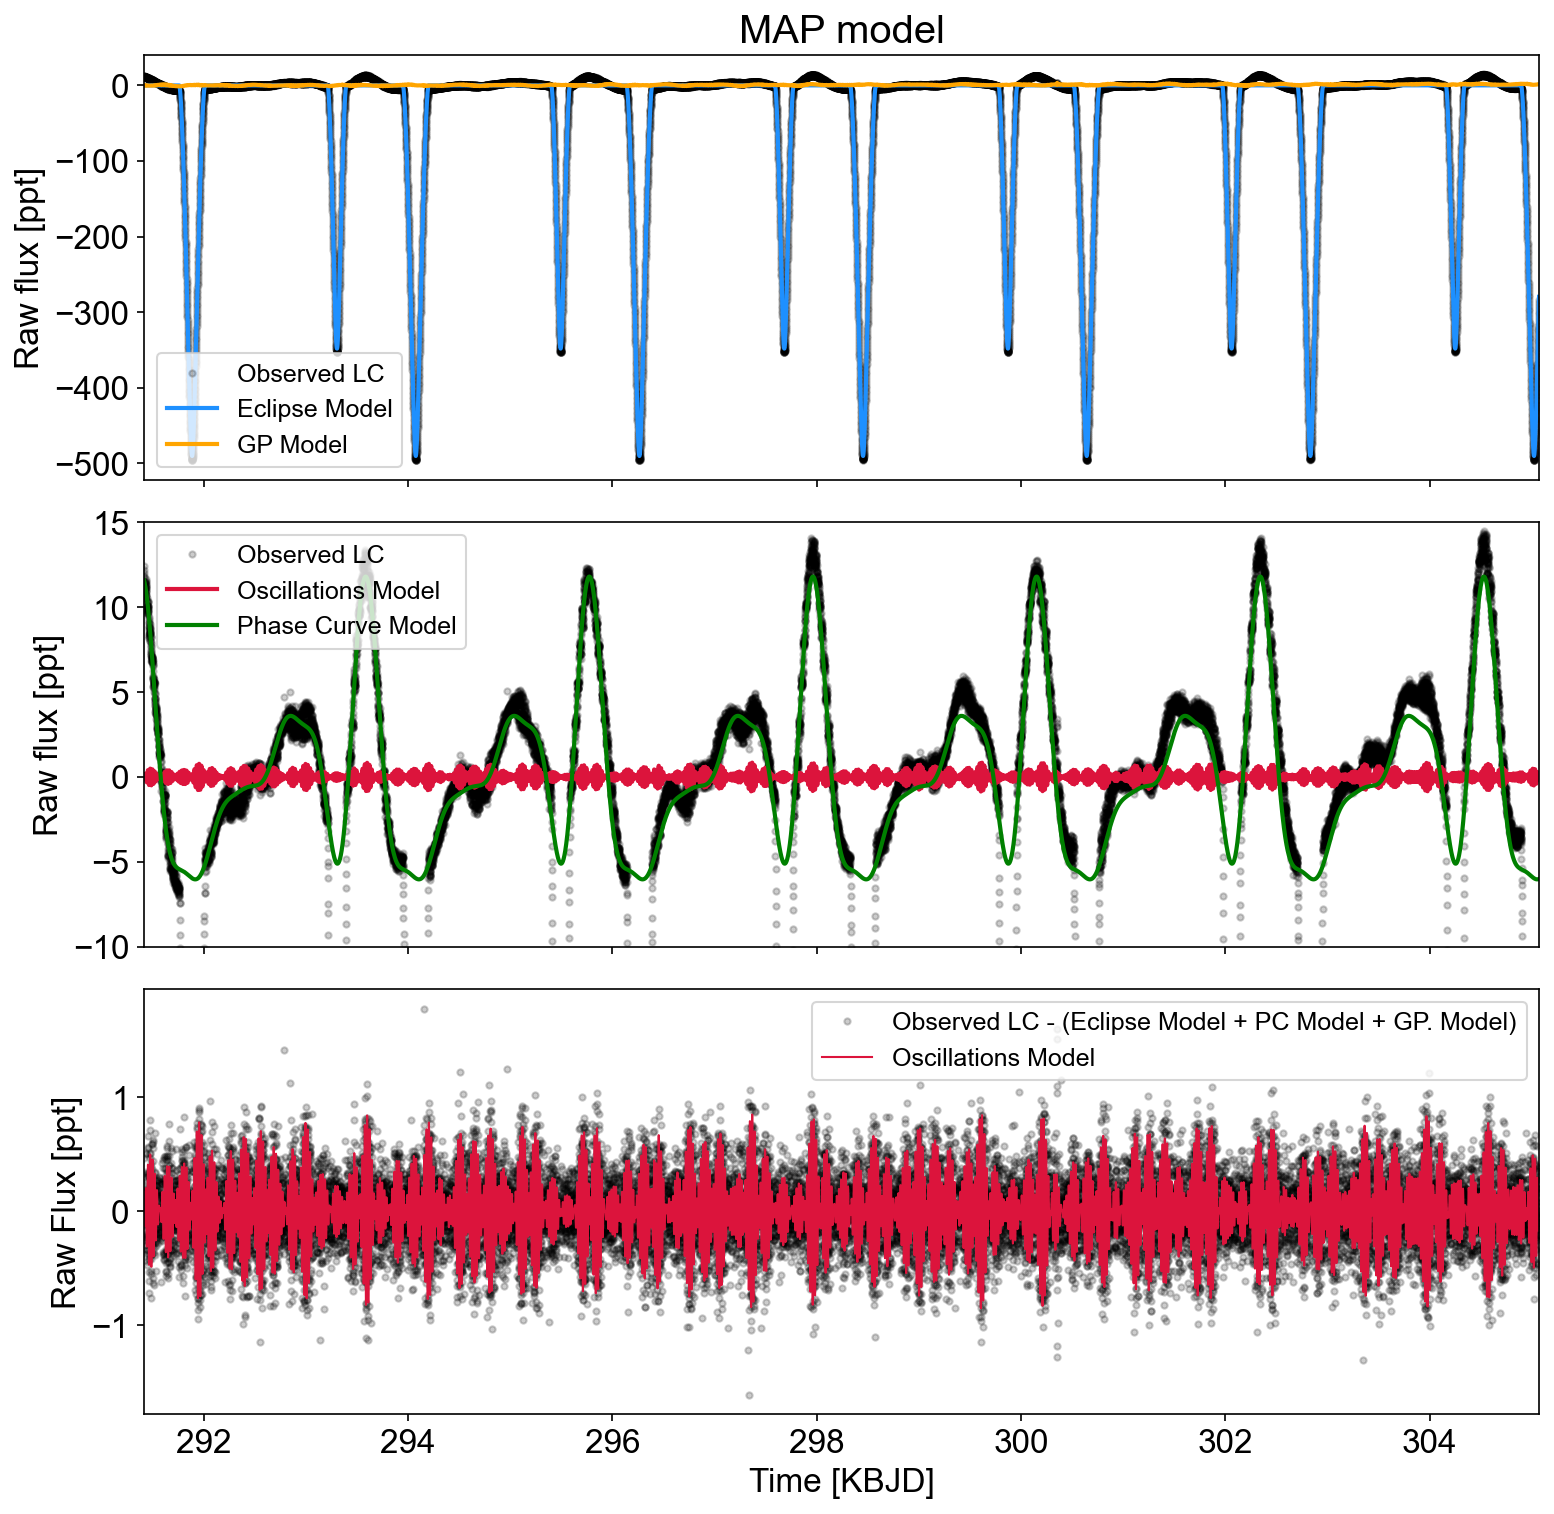

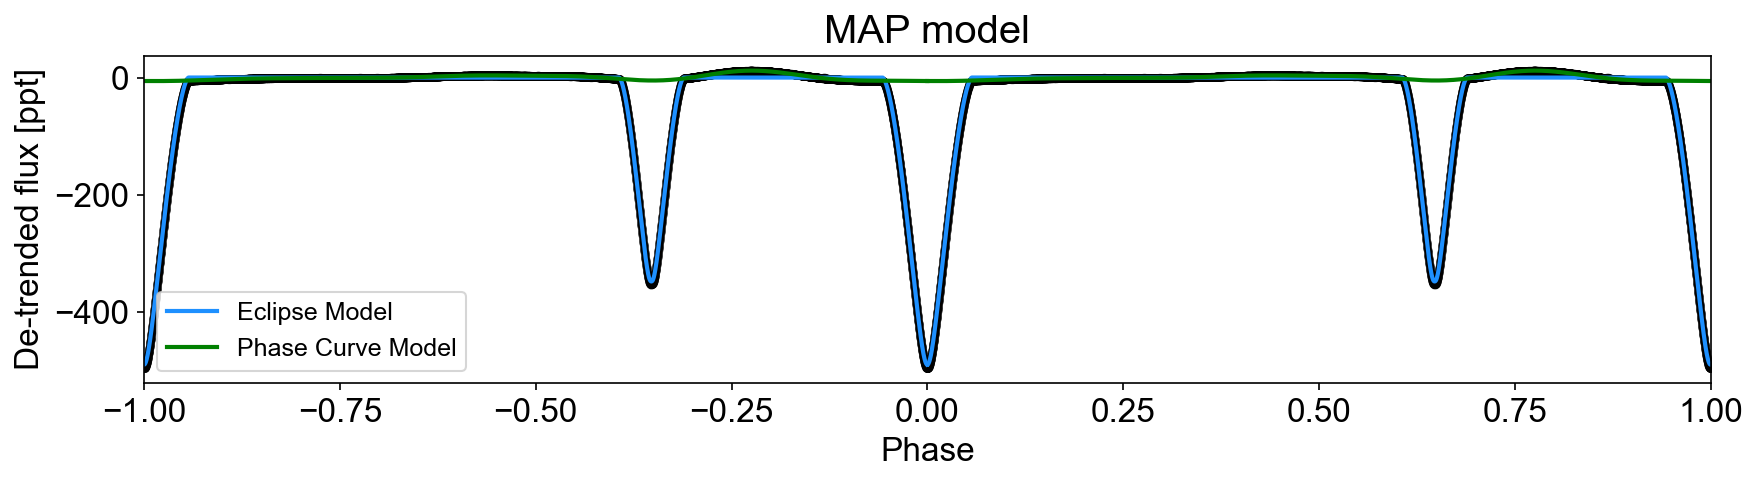

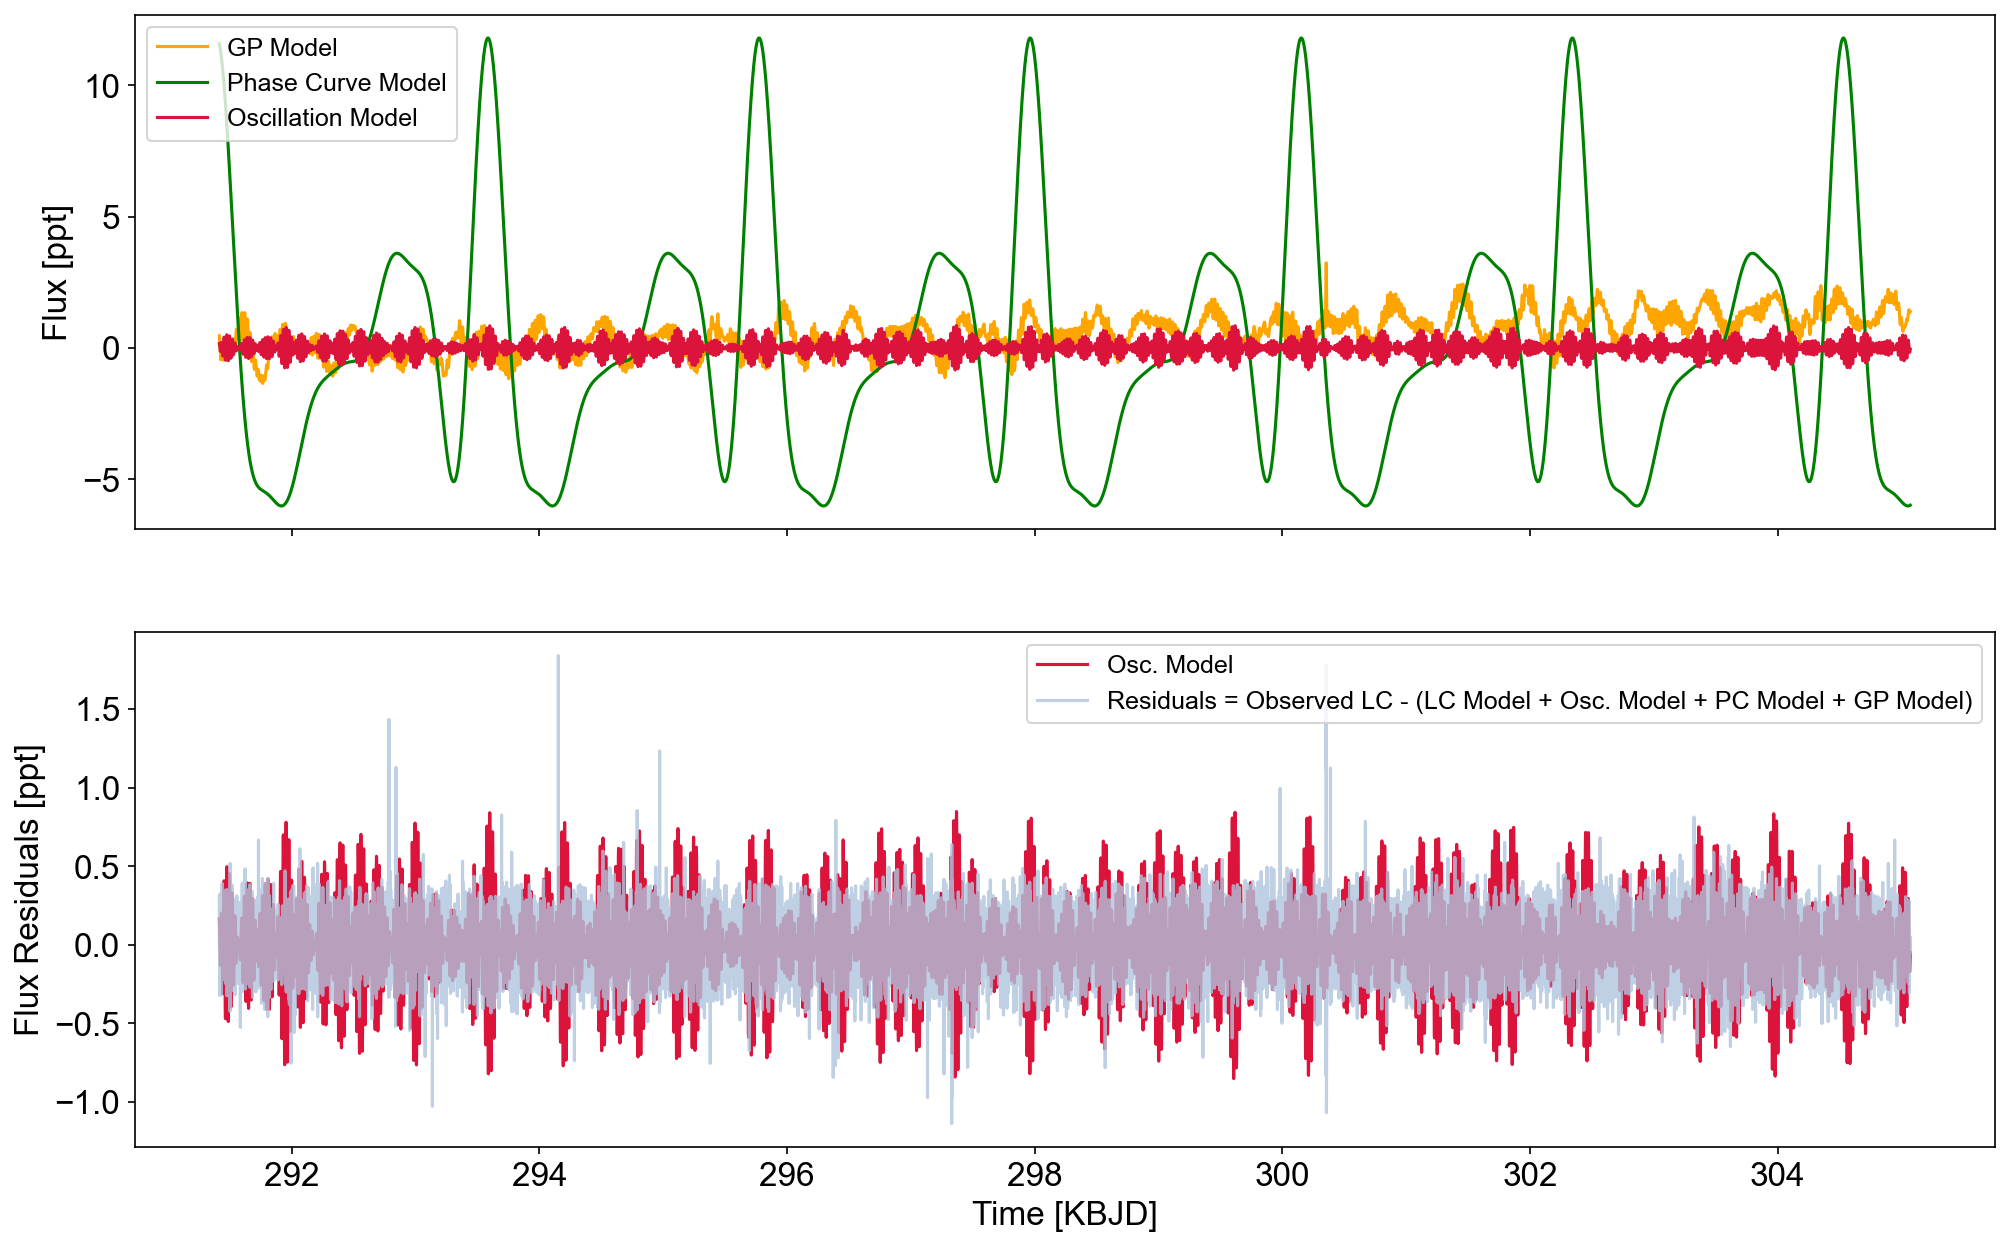

Found 4 frequencies
f = 44.31 1/d --> 0.0226 days, 0.54 hours, 32.50 min, 1949.81 sec
f = 47.97 1/d --> 0.0208 days, 0.50 hours, 30.02 min, 1800.96 sec
f = 46.58 1/d --> 0.0215 days, 0.52 hours, 30.91 min, 1854.87 sec
f = 44.78 1/d --> 0.0223 days, 0.54 hours, 32.16 min, 1929.48 sec


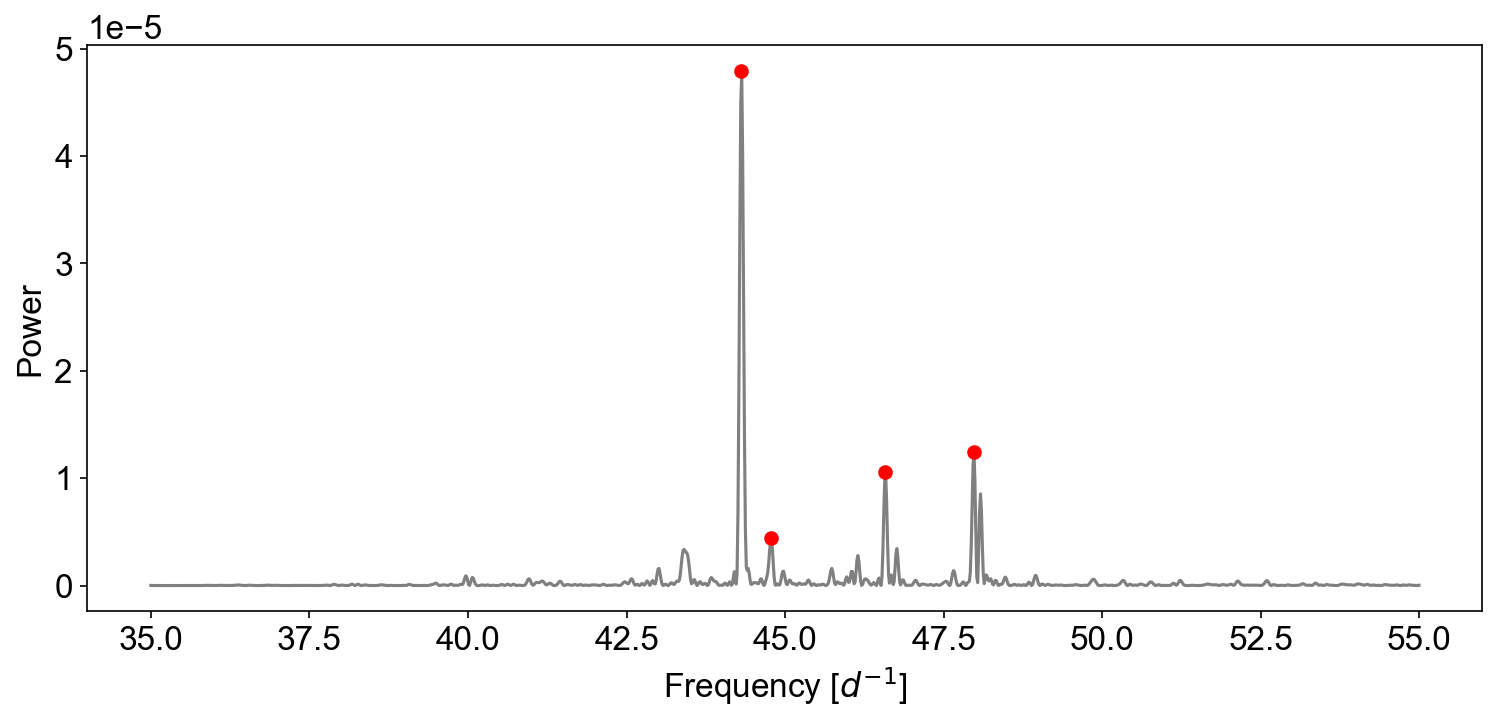


               ITERATION 1
--------------------------------------------
[44.3120377  47.9744787  46.57998833 44.7789137 ] 14
0.18542993772080585 0.7683362474628092 0.07105303423822736
DTD_det __str__ = 1.8909660721754805e+149


optimizing logp for variables: [u2, u1, b, k, s, R1]


message: Desired error not necessarily achieved due to precision loss.
logp: -478798.1012467289 -> -14509.670900284147
optimizing logp for variables: [sigma_lc, ell_lc, S_tot_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -14509.670900284147 -> -1327.828242210649
optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1]


message: Desired error not necessarily achieved due to precision loss.
logp: -1327.828242210649 -> 1652.2994431052082


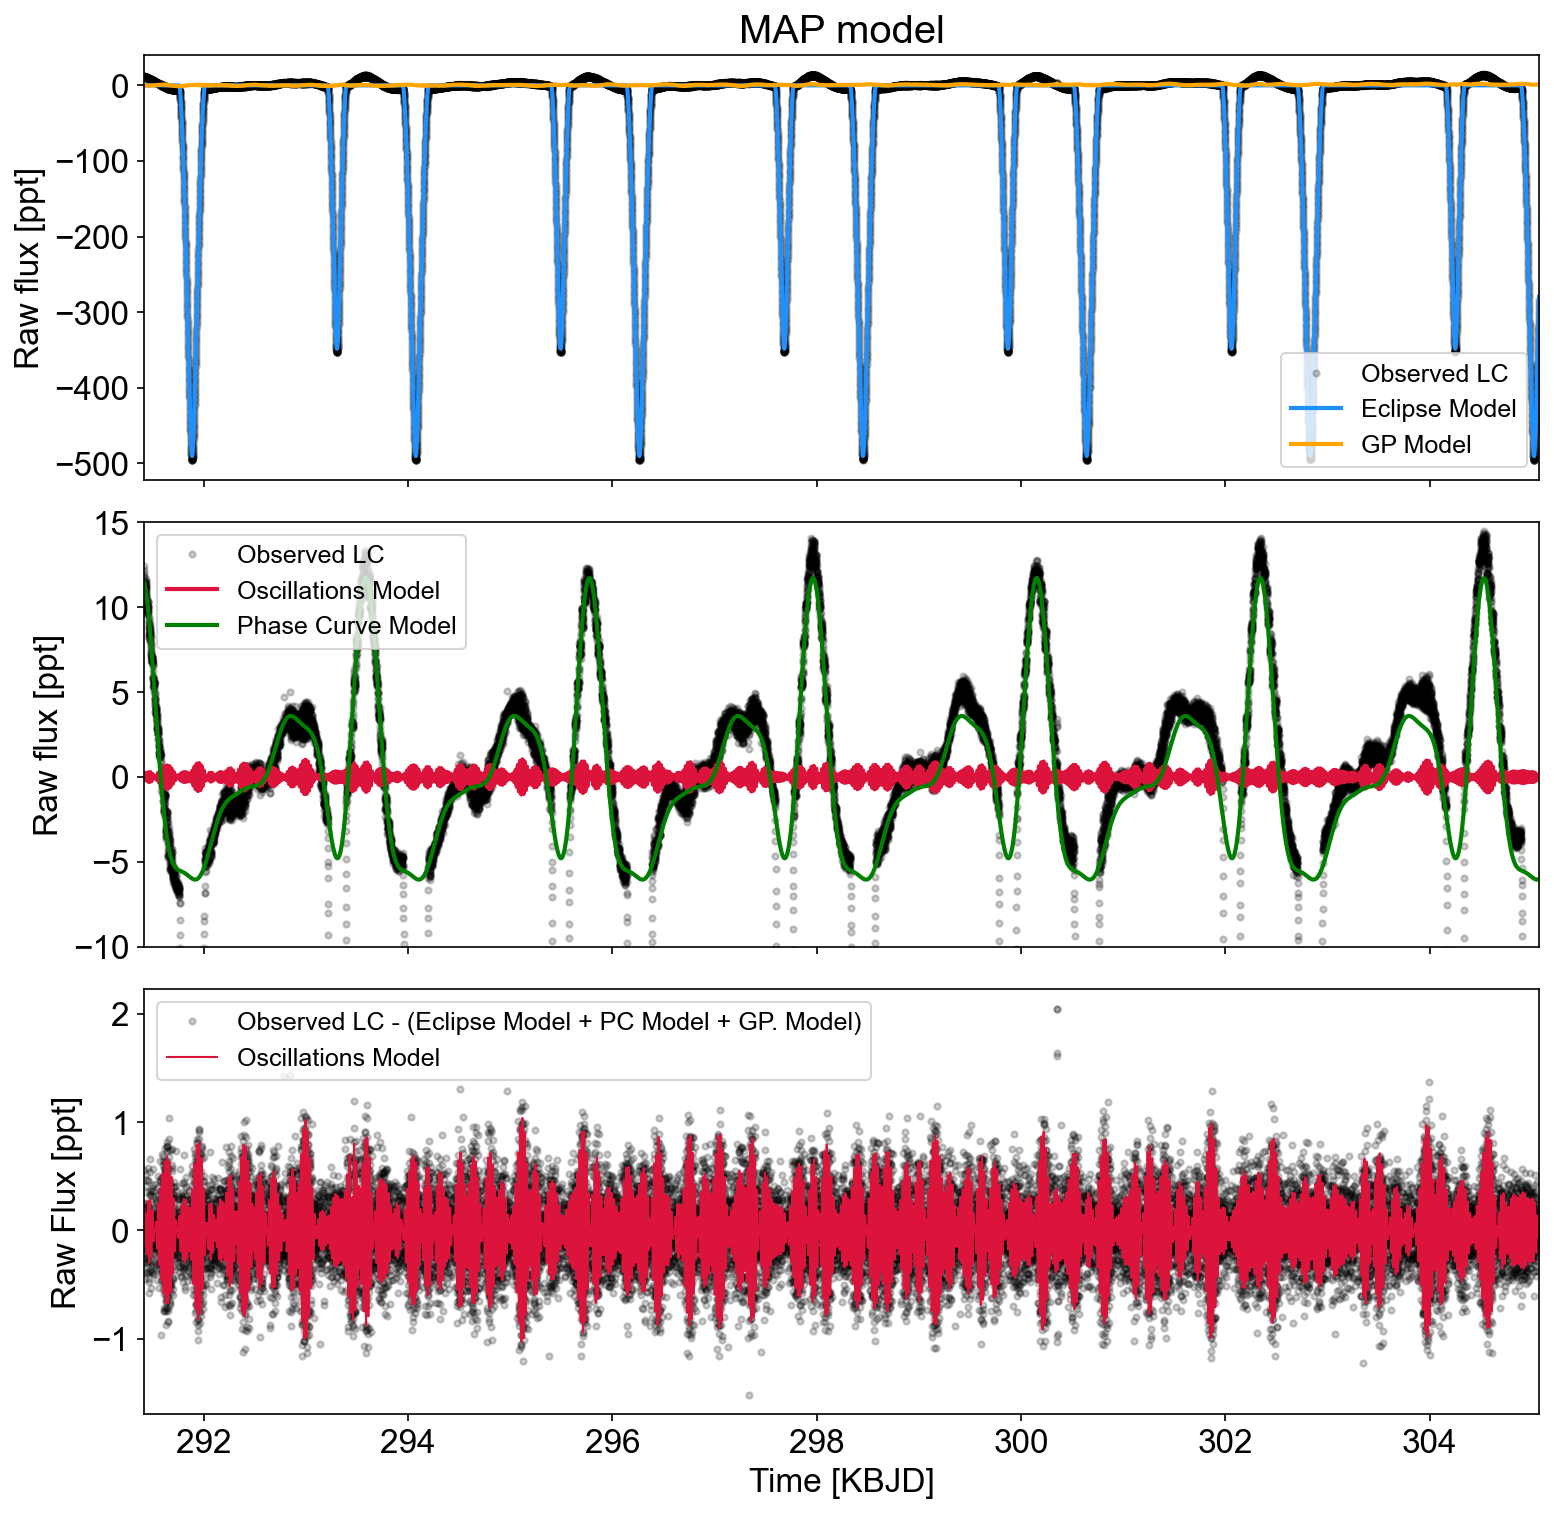

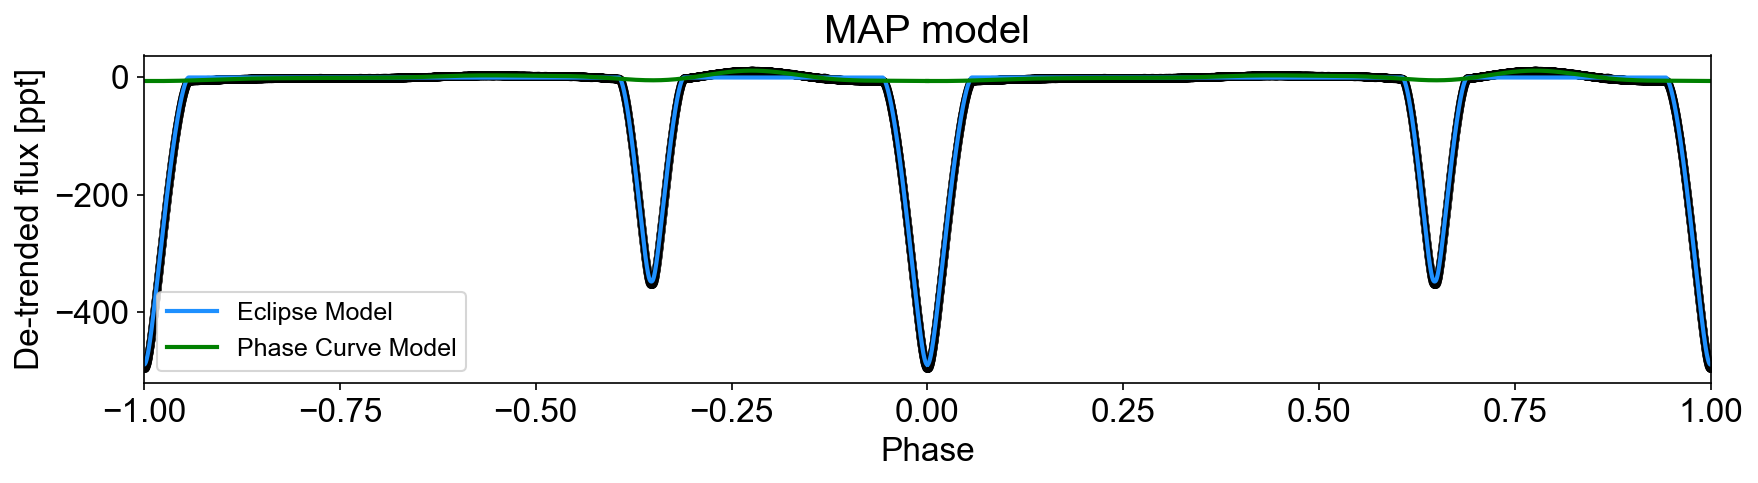

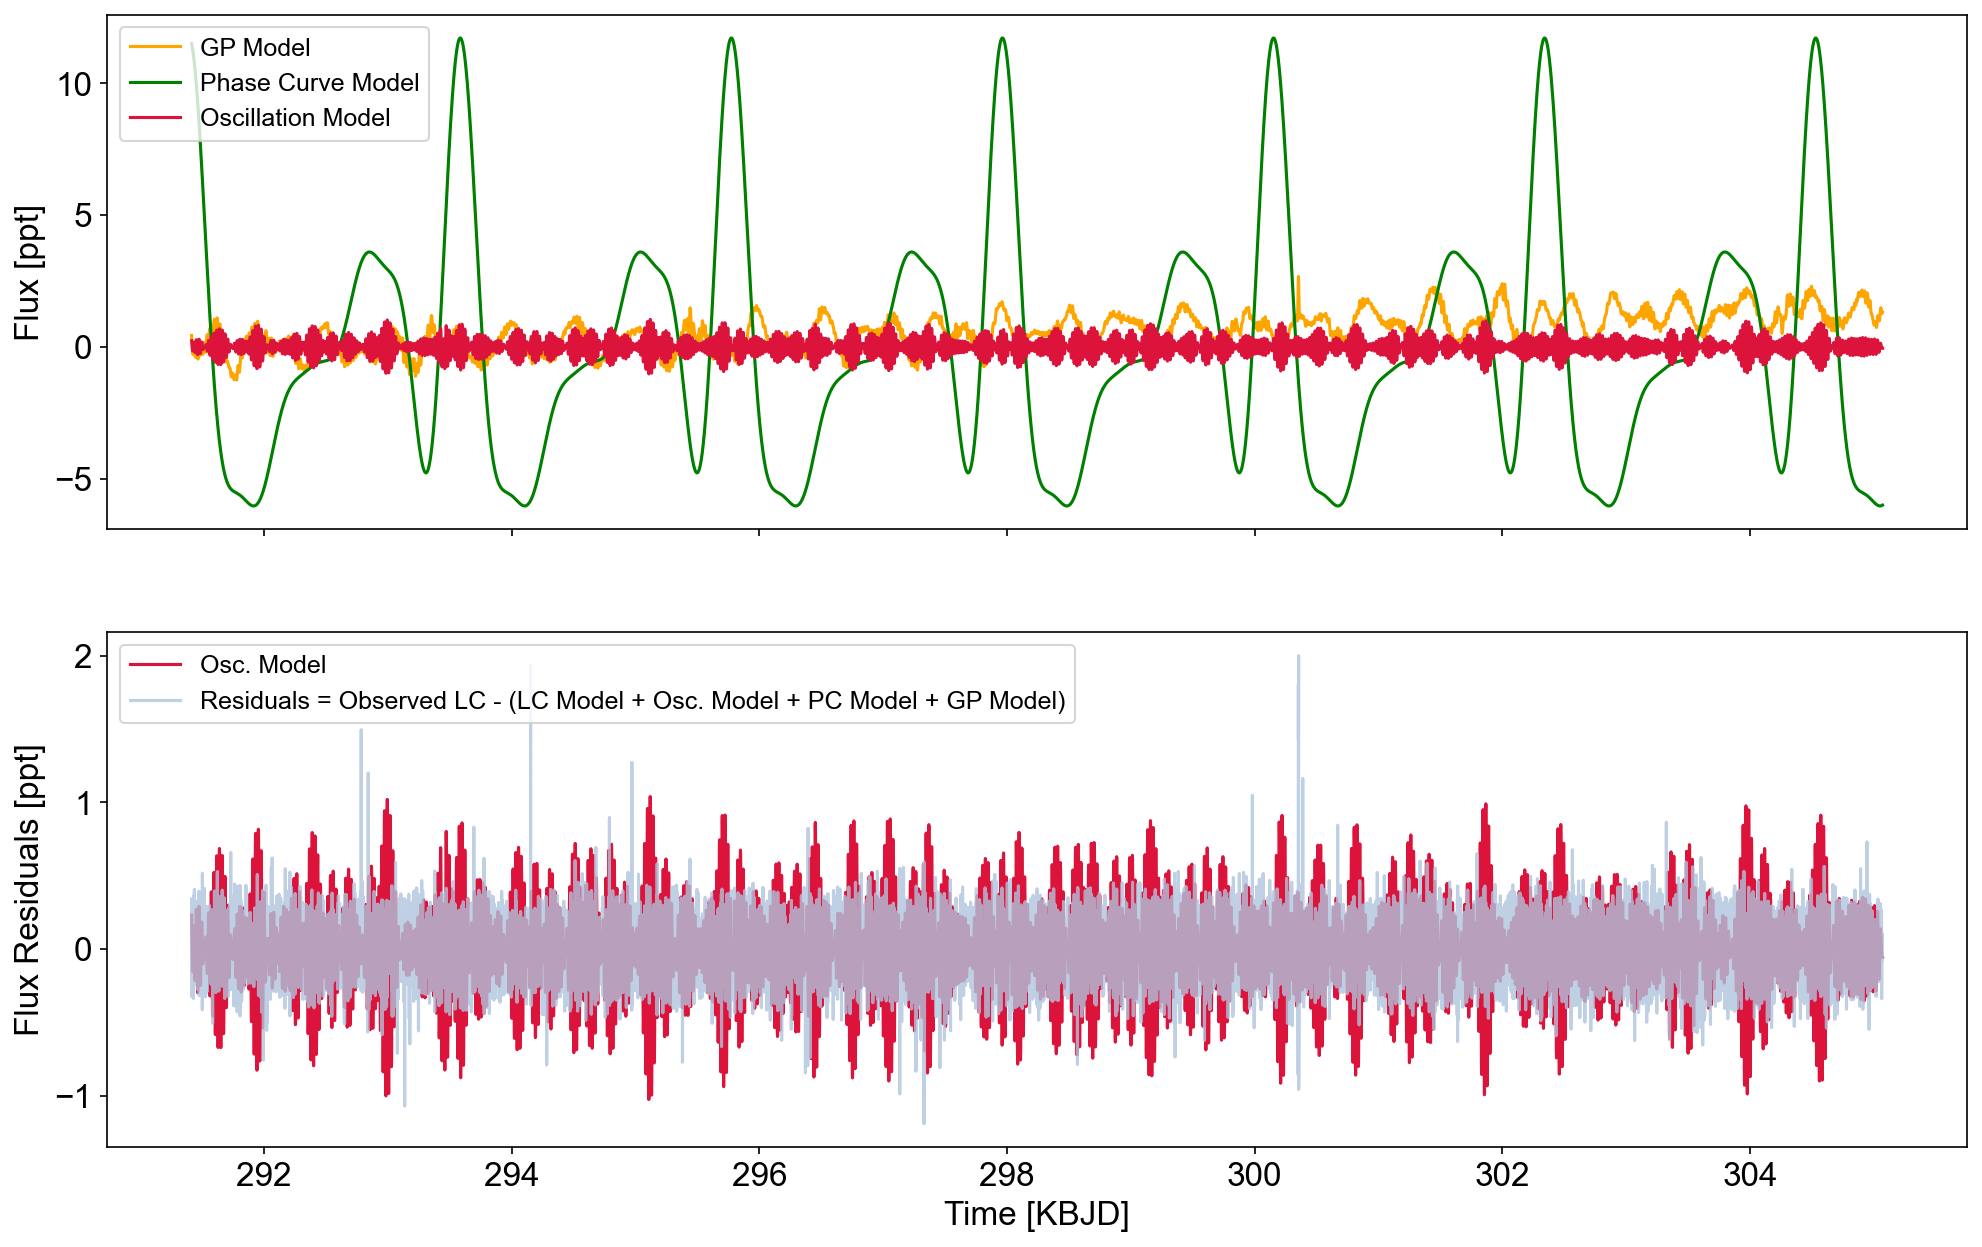

Found 4 frequencies
f = 43.45 1/d --> 0.0230 days, 0.55 hours, 33.14 min, 1988.31 sec
f = 48.10 1/d --> 0.0208 days, 0.50 hours, 29.94 min, 1796.44 sec
f = 46.15 1/d --> 0.0217 days, 0.52 hours, 31.20 min, 1872.00 sec
f = 46.76 1/d --> 0.0214 days, 0.51 hours, 30.79 min, 1847.68 sec


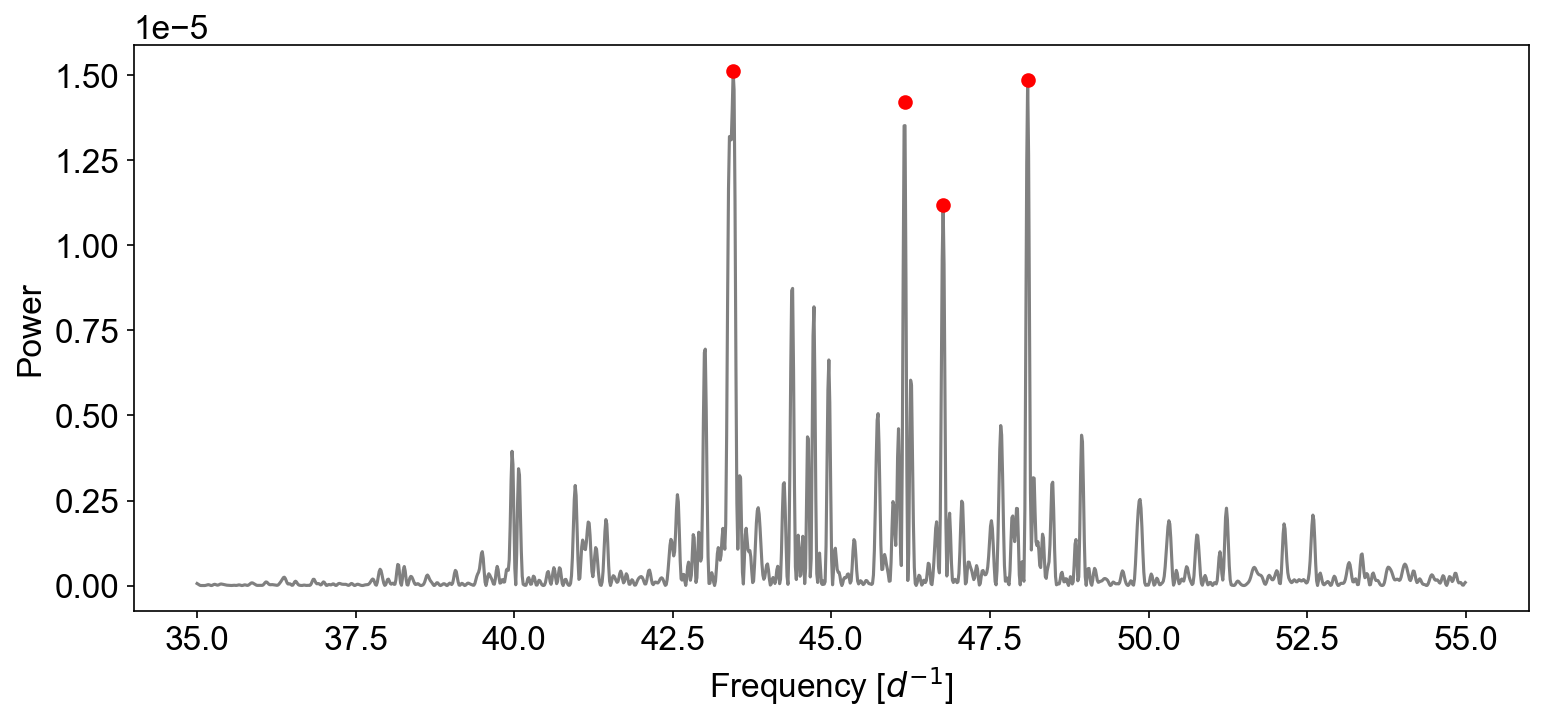


               ITERATION 2
--------------------------------------------
[43.45407324 48.09506667 46.1538972  46.76146299] 18
0.18754837586454373 0.5066131906356546 0.08499117729937207
DTD_det __str__ = 7.819457821633389e+196


optimizing logp for variables: [u2, u1, b, k, s, R1]


message: Desired error not necessarily achieved due to precision loss.
logp: -724089.6740105071 -> -25449.172514422036
optimizing logp for variables: [sigma_lc, ell_lc, S_tot_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -25449.172514422036 -> -1257.2148642369525
optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1]


message: Desired error not necessarily achieved due to precision loss.
logp: -1257.2148642369525 -> 1867.313832417712


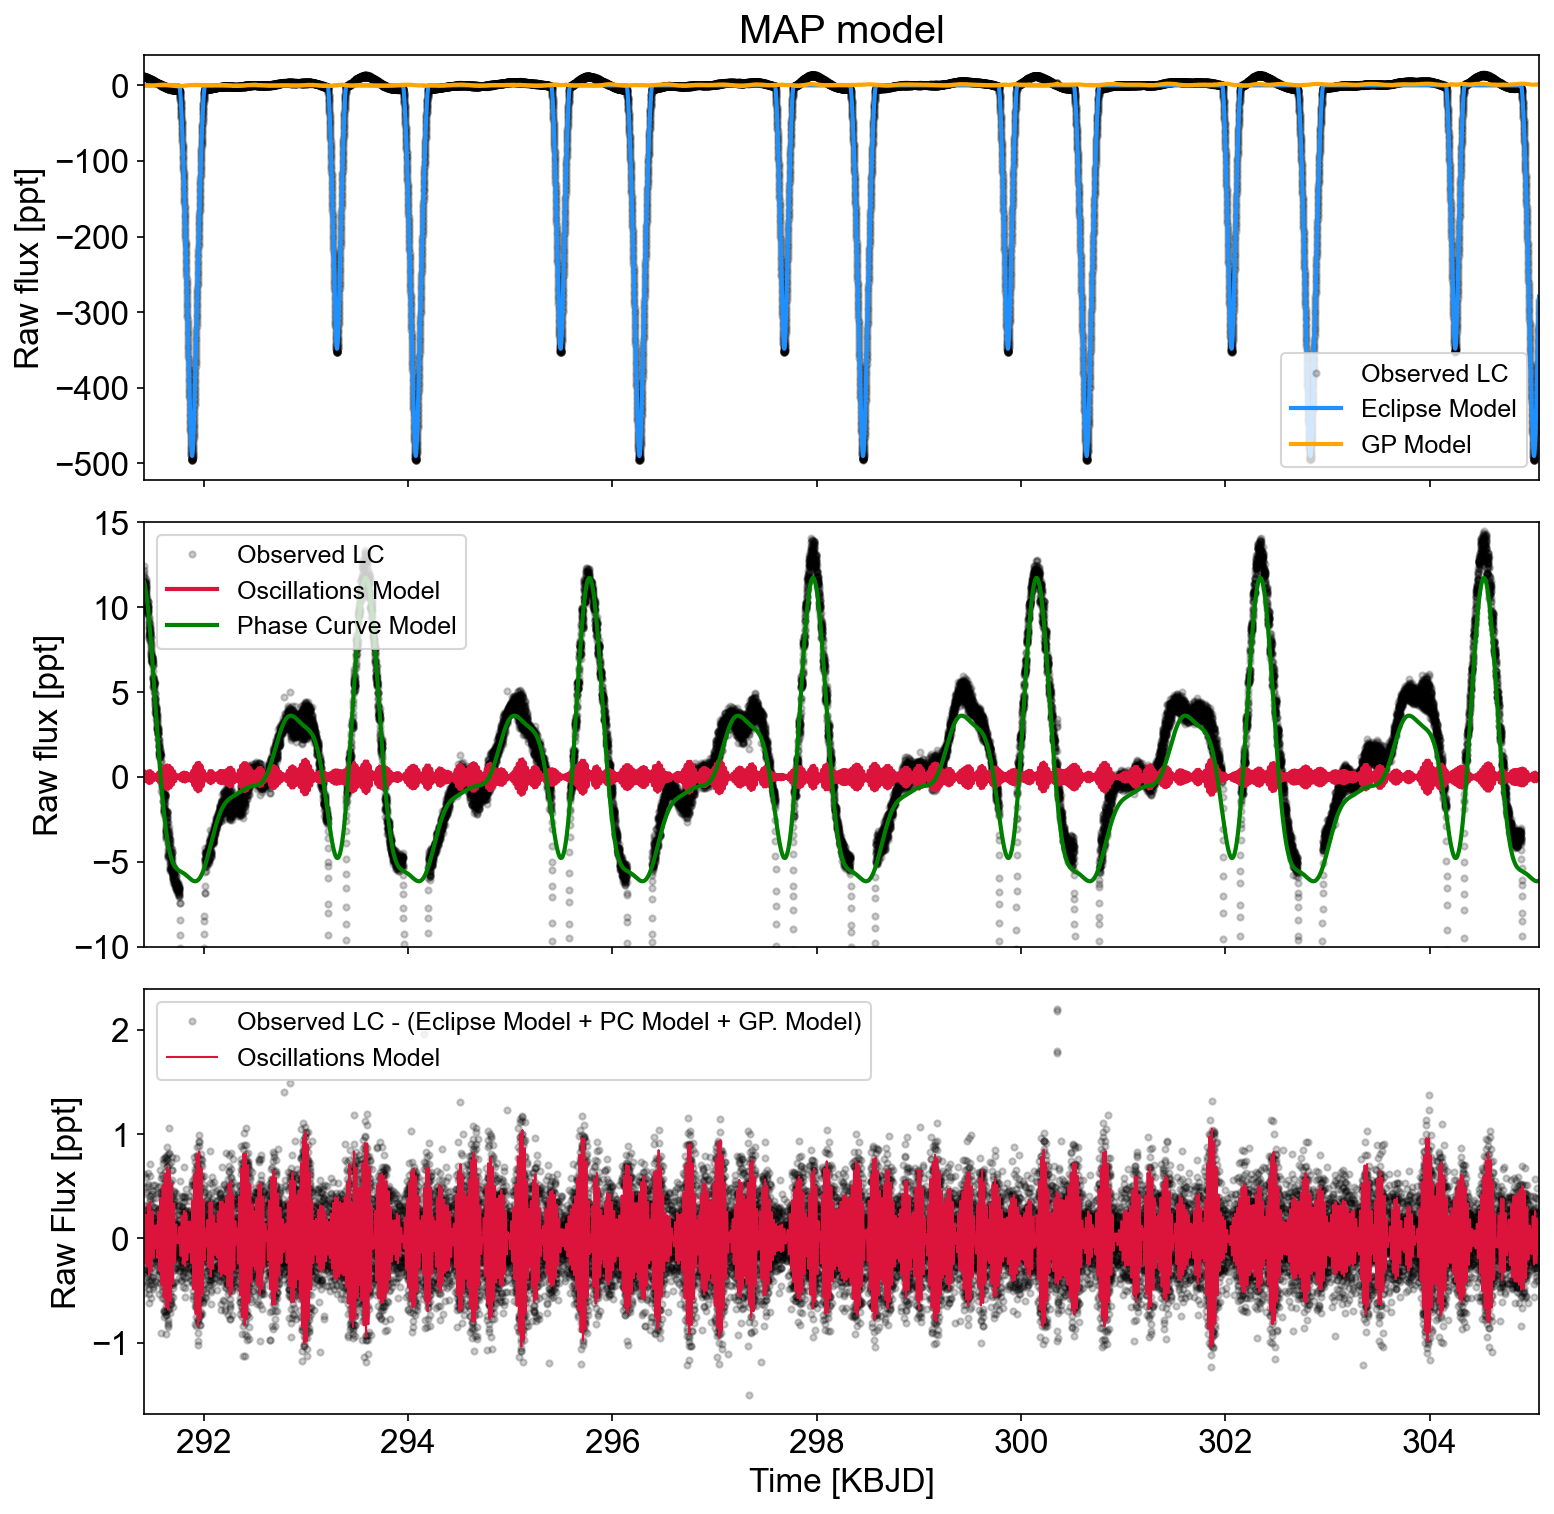

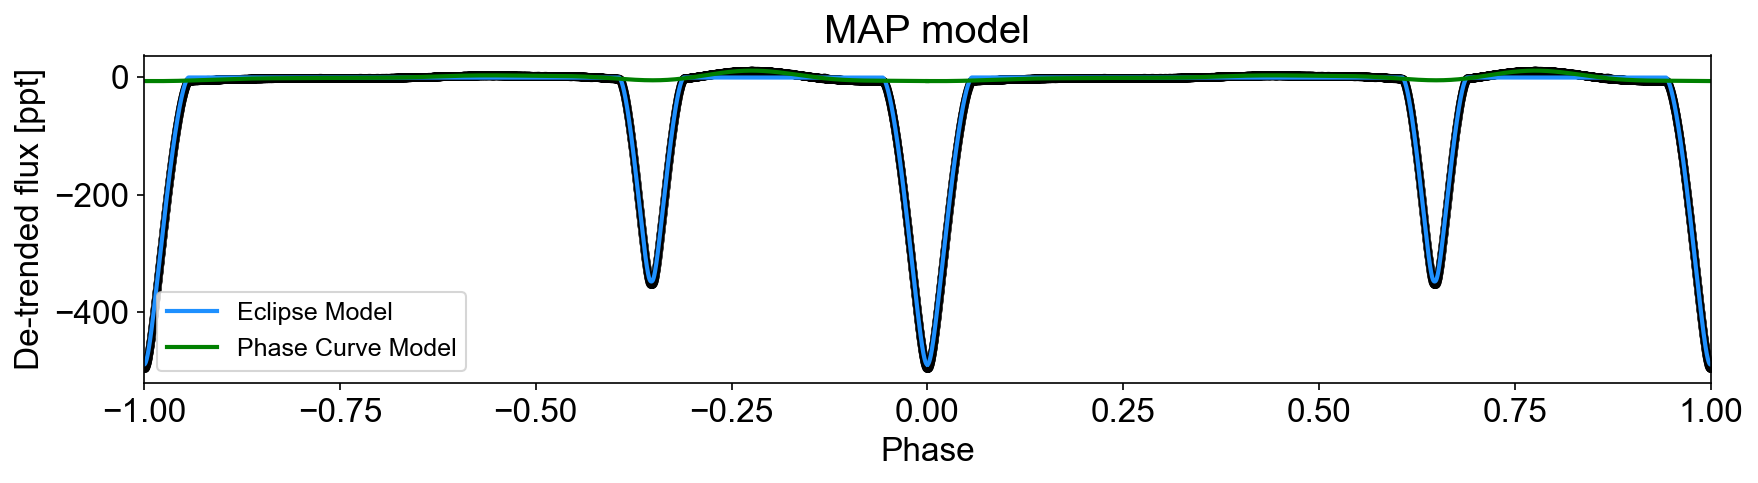

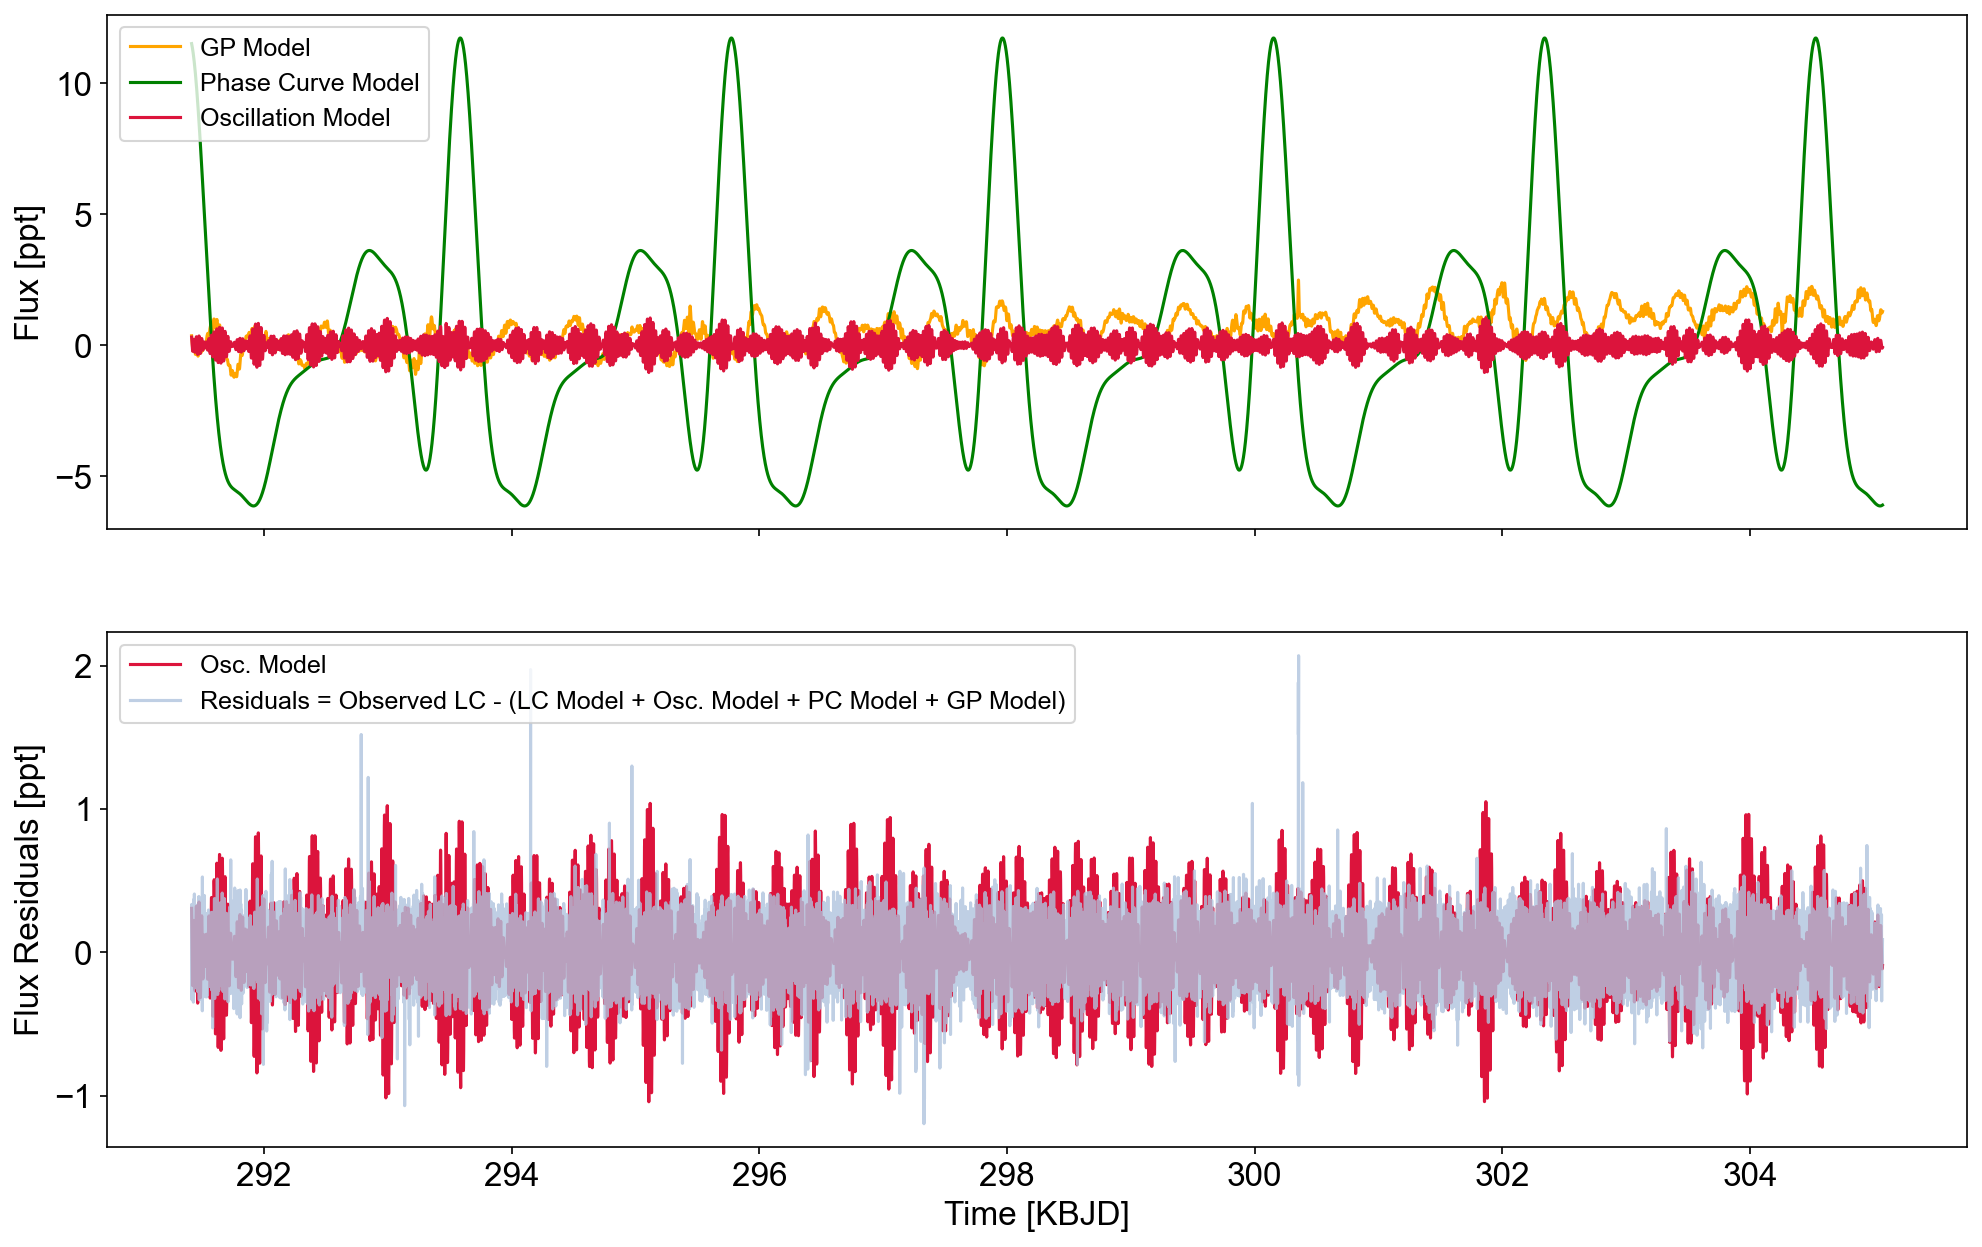

Found 5 frequencies
f = 43.39 1/d --> 0.0230 days, 0.55 hours, 33.19 min, 1991.13 sec
f = 44.72 1/d --> 0.0224 days, 0.54 hours, 32.20 min, 1931.86 sec
f = 44.38 1/d --> 0.0225 days, 0.54 hours, 32.45 min, 1946.71 sec
f = 44.96 1/d --> 0.0222 days, 0.53 hours, 32.03 min, 1921.77 sec
f = 43.01 1/d --> 0.0233 days, 0.56 hours, 33.48 min, 2009.01 sec


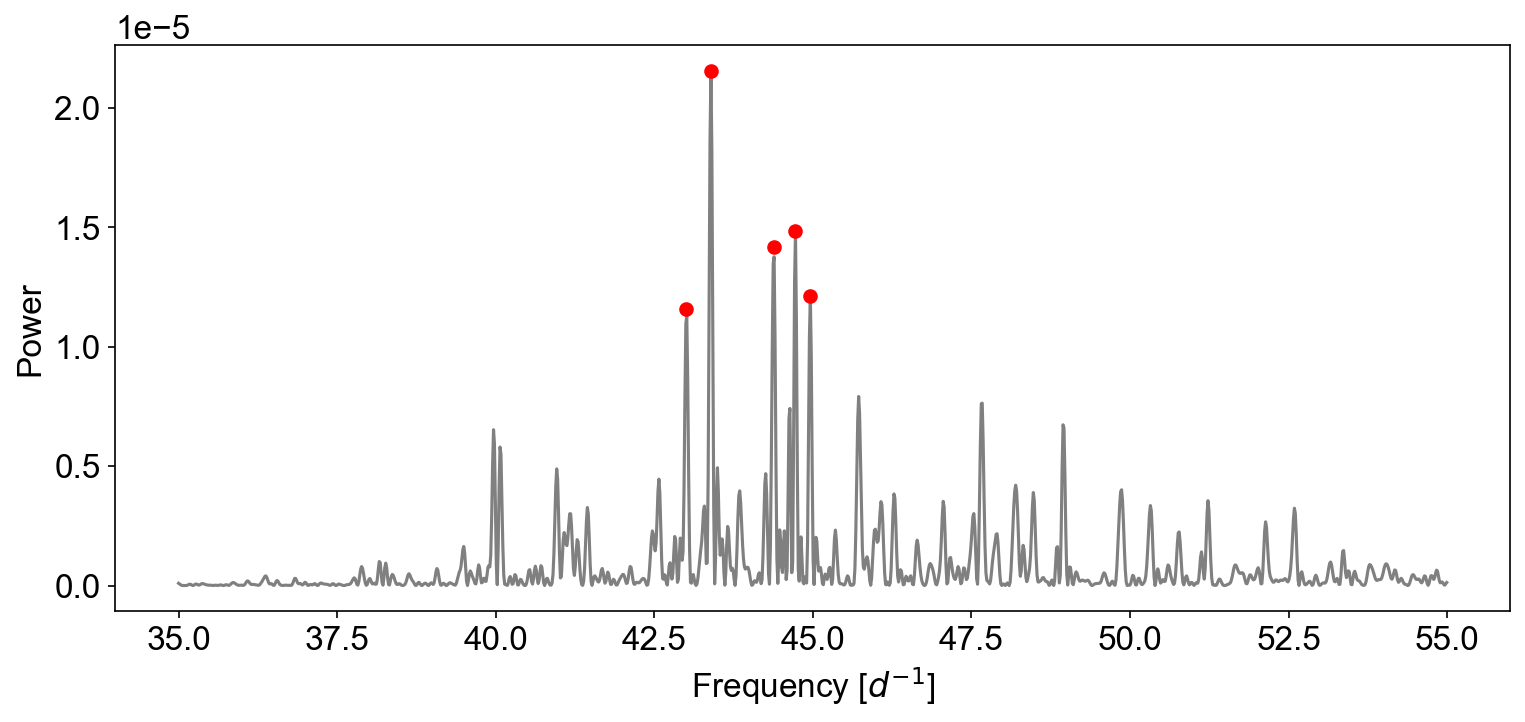


               ITERATION 3
--------------------------------------------
[43.39241989 44.72364663 44.38259912 44.95861148 43.00620432] 23
0.1882961510622054 0.46634726101096513 0.09279658851660504
DTD_det __str__ = 5.531987664943926e+247


optimizing logp for variables: [u2, u1, b, k, s, R1]


message: Desired error not necessarily achieved due to precision loss.
logp: -795829.6899901823 -> -40948.22799395525
optimizing logp for variables: [sigma_lc, ell_lc, S_tot_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -40948.22799395525 -> -1252.250743999452
optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1]


message: Desired error not necessarily achieved due to precision loss.
logp: -1252.250743999452 -> -1239.156485409092


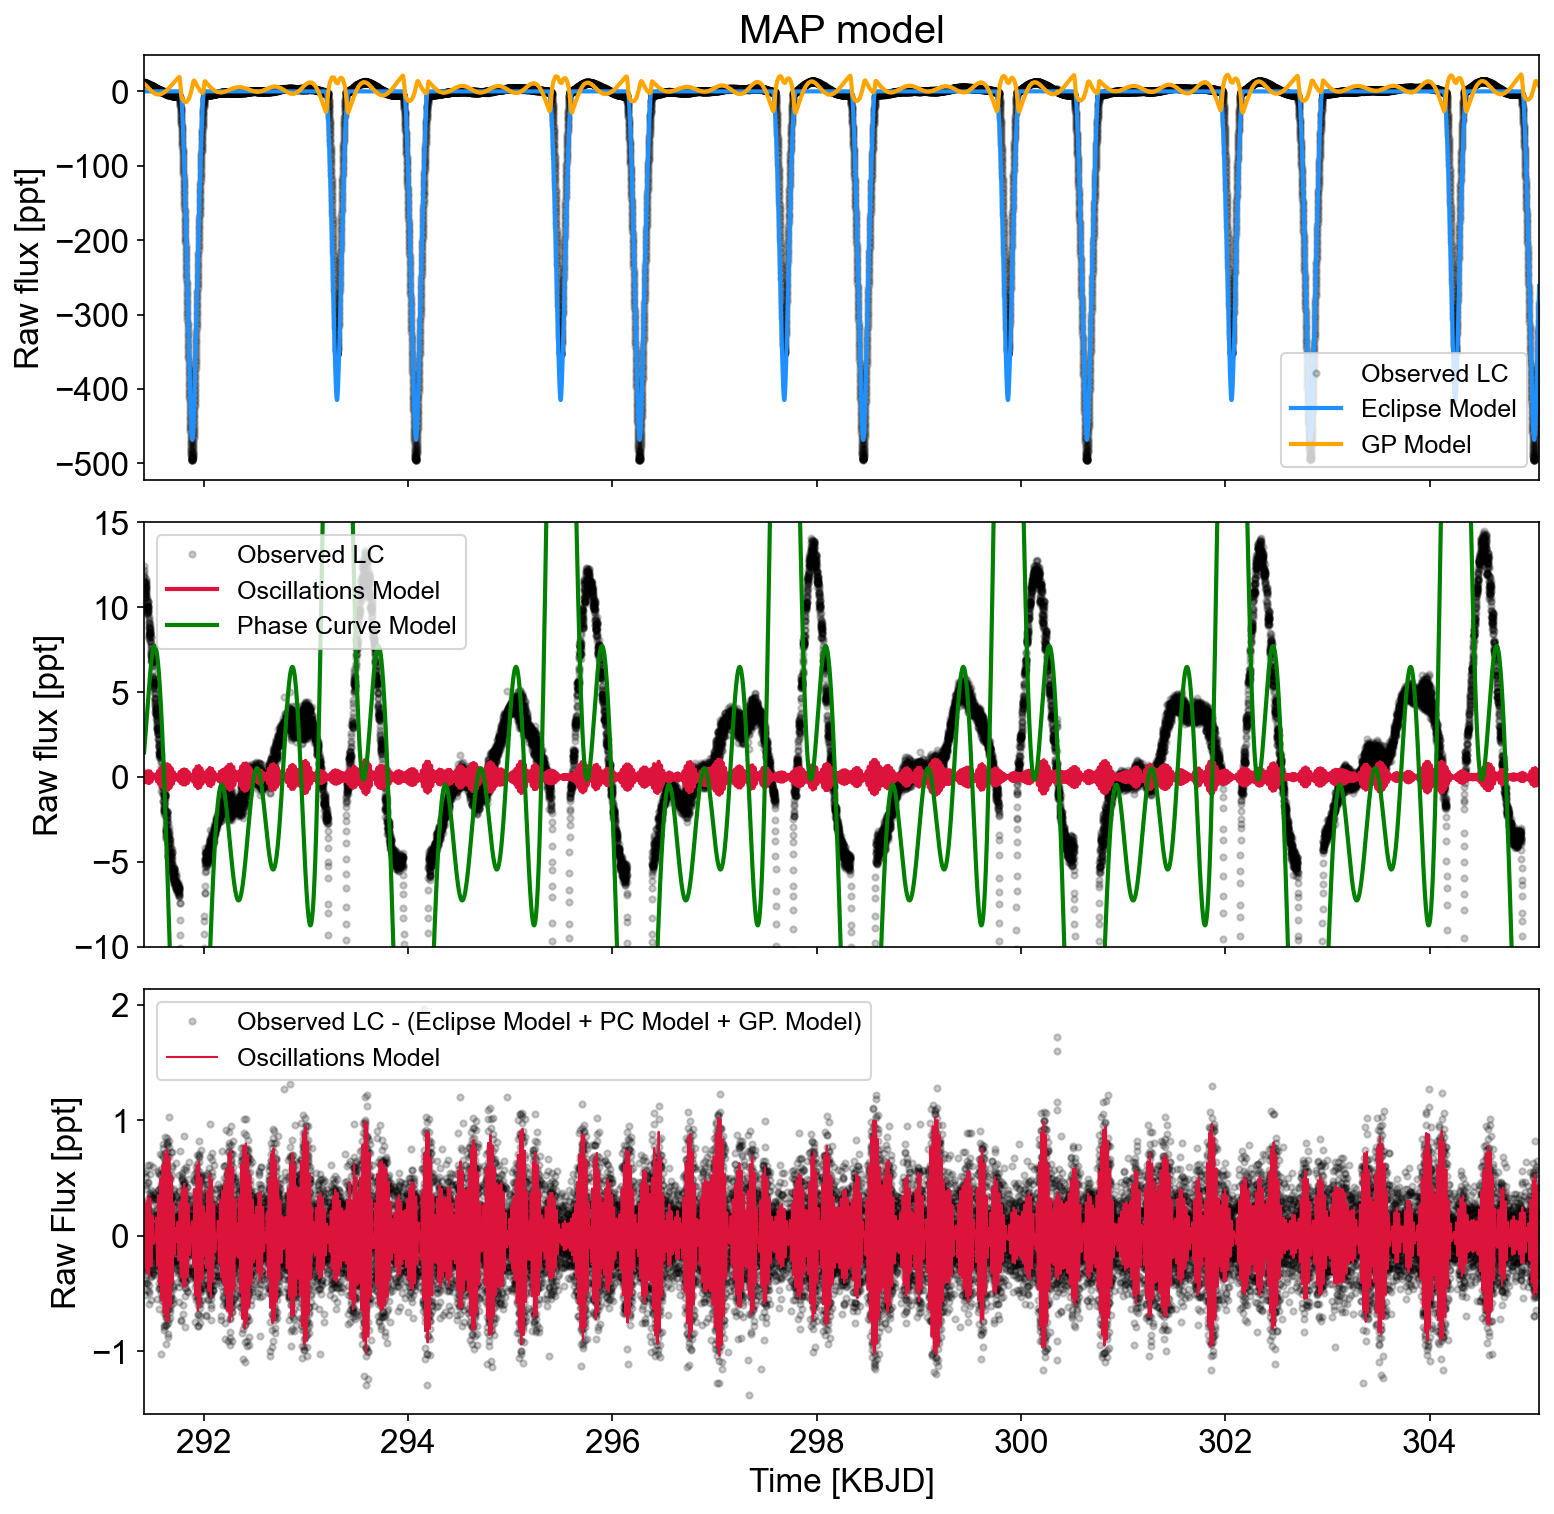

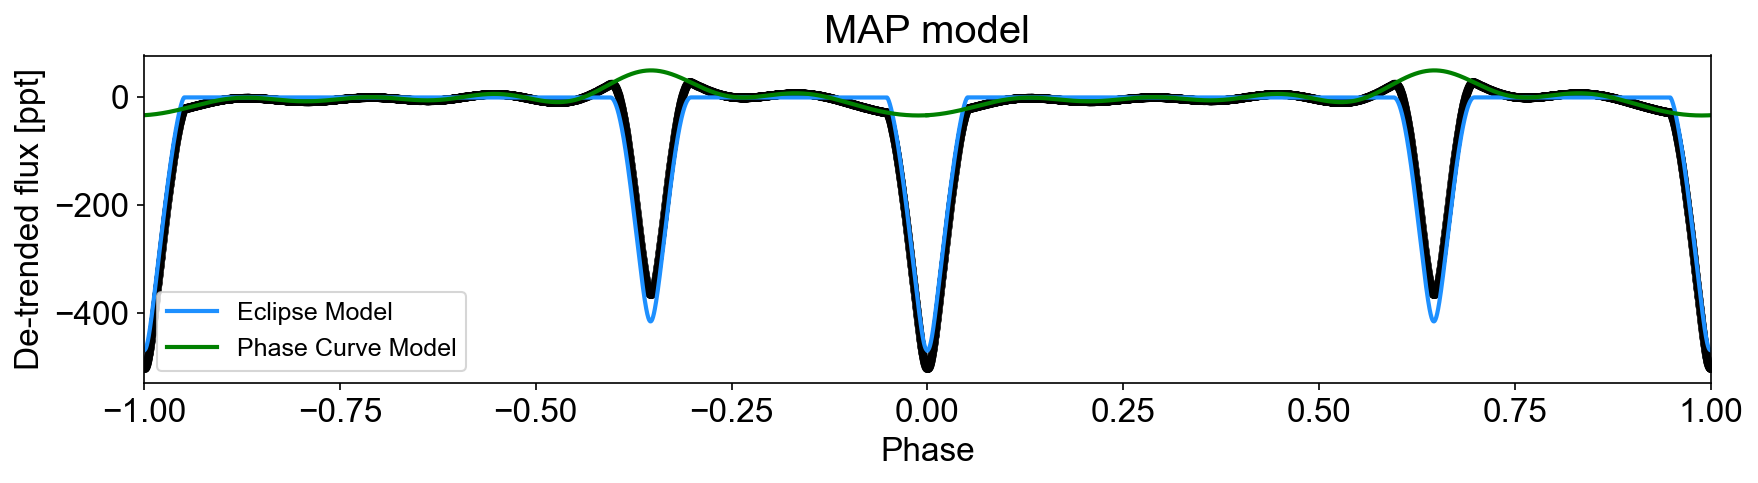

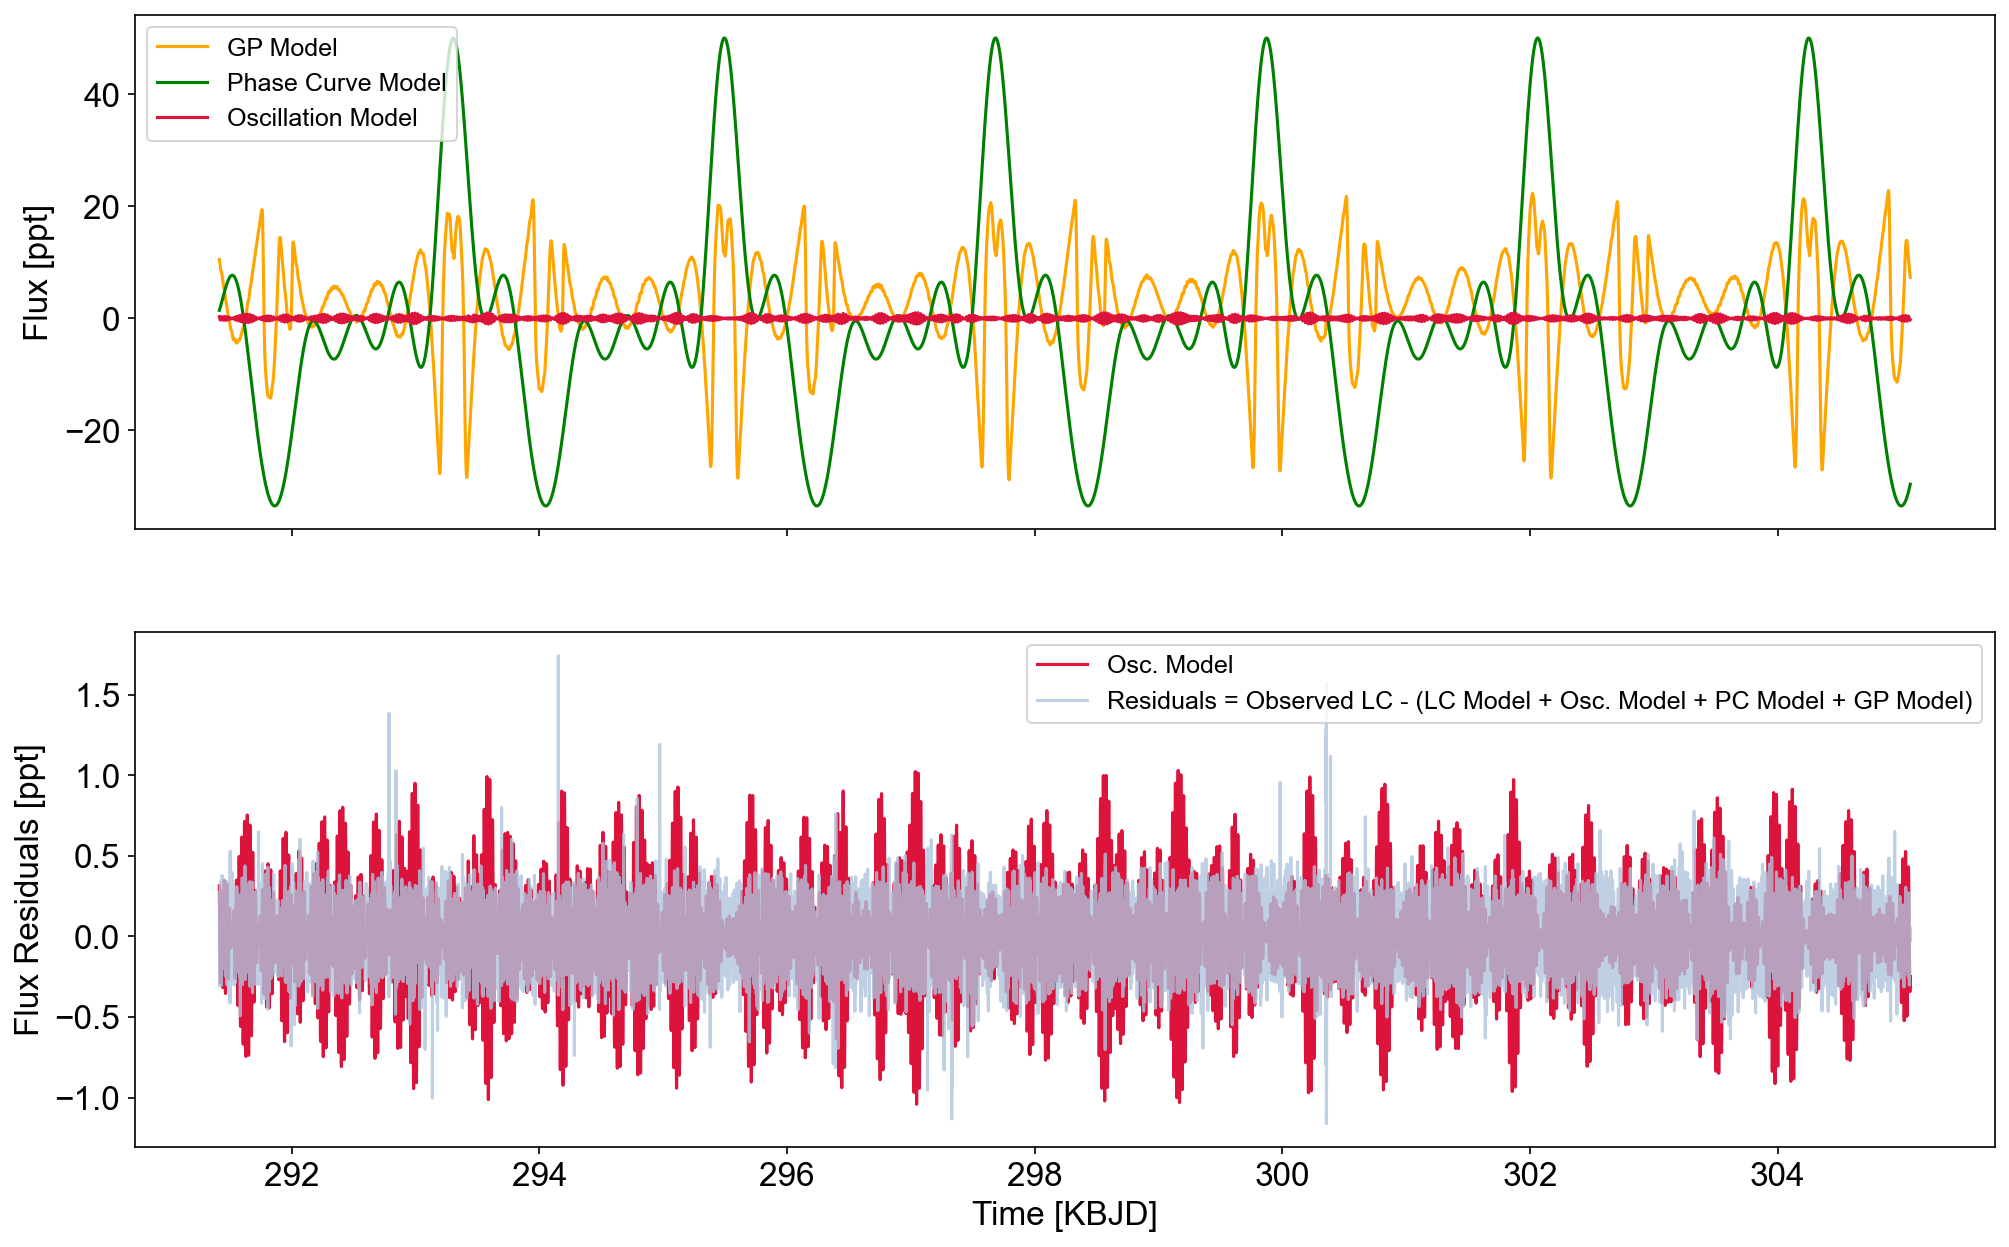

Found 5 frequencies
f = 45.69 1/d --> 0.0219 days, 0.53 hours, 31.52 min, 1890.99 sec
f = 53.90 1/d --> 0.0186 days, 0.45 hours, 26.71 min, 1602.83 sec
f = 53.44 1/d --> 0.0187 days, 0.45 hours, 26.94 min, 1616.67 sec
f = 54.82 1/d --> 0.0182 days, 0.44 hours, 26.27 min, 1576.13 sec
f = 52.98 1/d --> 0.0189 days, 0.45 hours, 27.18 min, 1630.70 sec


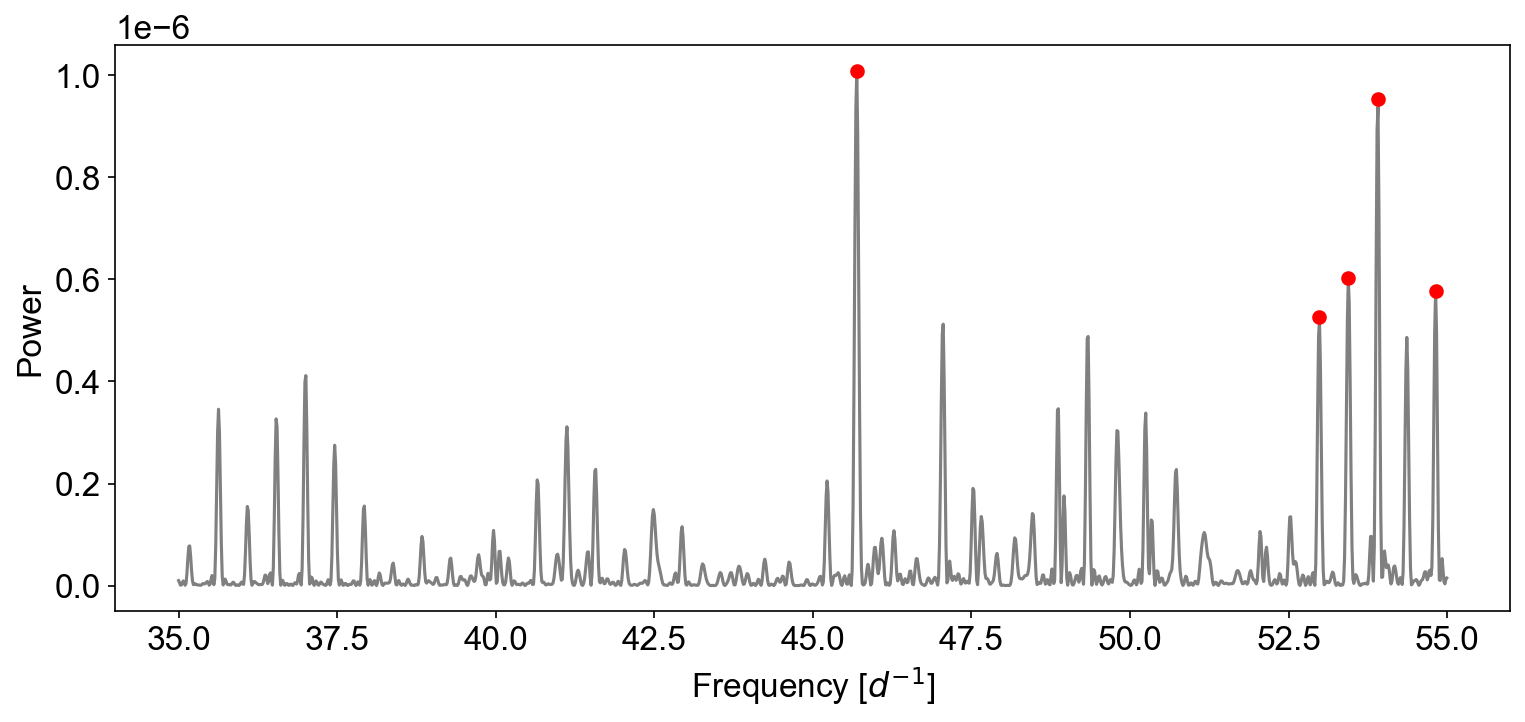


               ITERATION 4
--------------------------------------------
[45.69036265 53.904771   53.44320462 54.81782244 52.98345106] 28
0.1844365948867409 590.2408905412311 0.5354585918446377
DTD_det __str__ = 7.830906476830354e+206


optimizing logp for variables: [u2, u1, b, k, s, R1]


message: Desired error not necessarily achieved due to precision loss.
logp: -5256.858449078937 -> -710.8756867920094
optimizing logp for variables: [sigma_lc, ell_lc, S_tot_lc]


message: Optimization terminated successfully.
logp: -710.8756867920094 -> -578.0174502752558
optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1]


message: Desired error not necessarily achieved due to precision loss.
logp: -578.0174502752558 -> -541.0792505102171


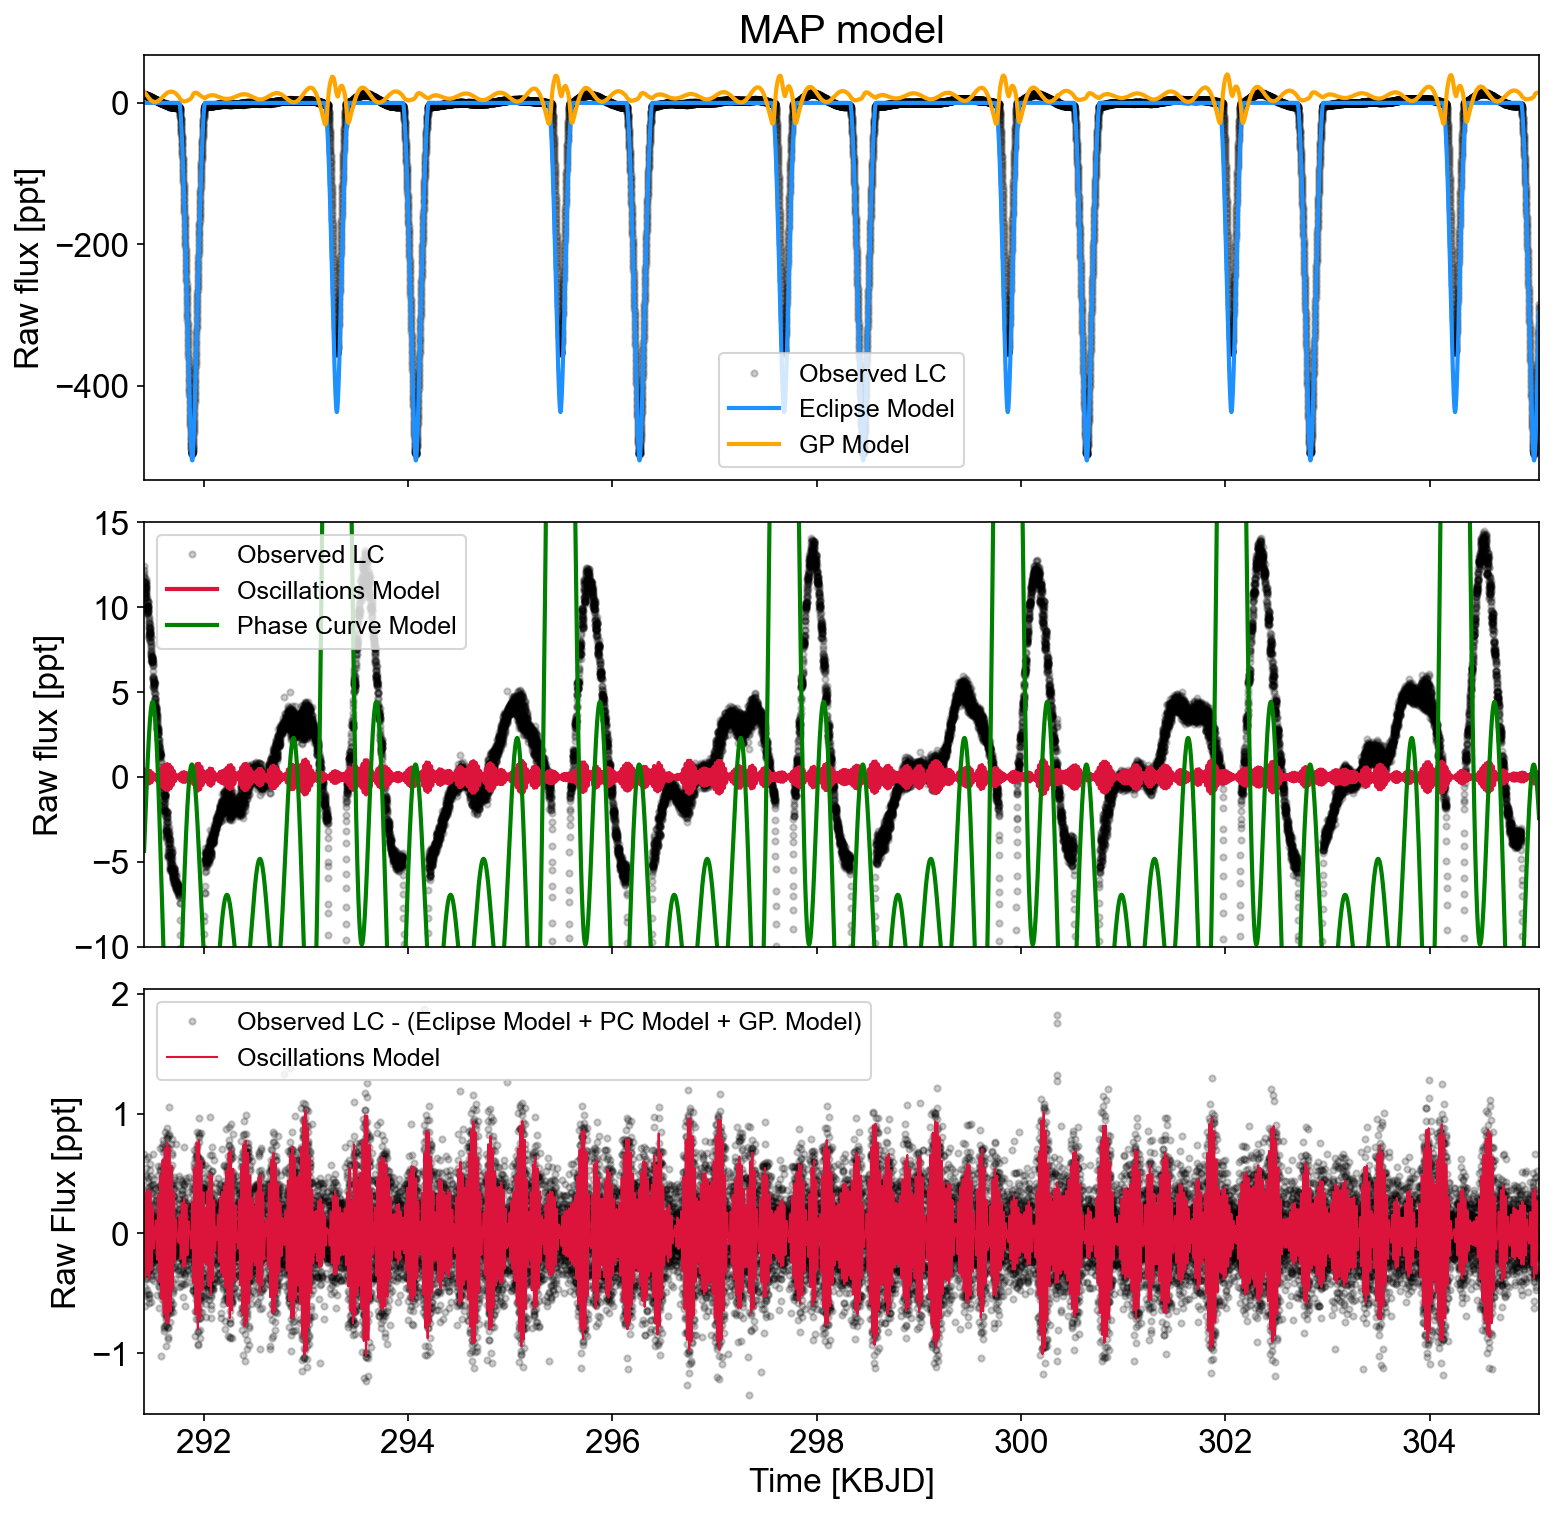

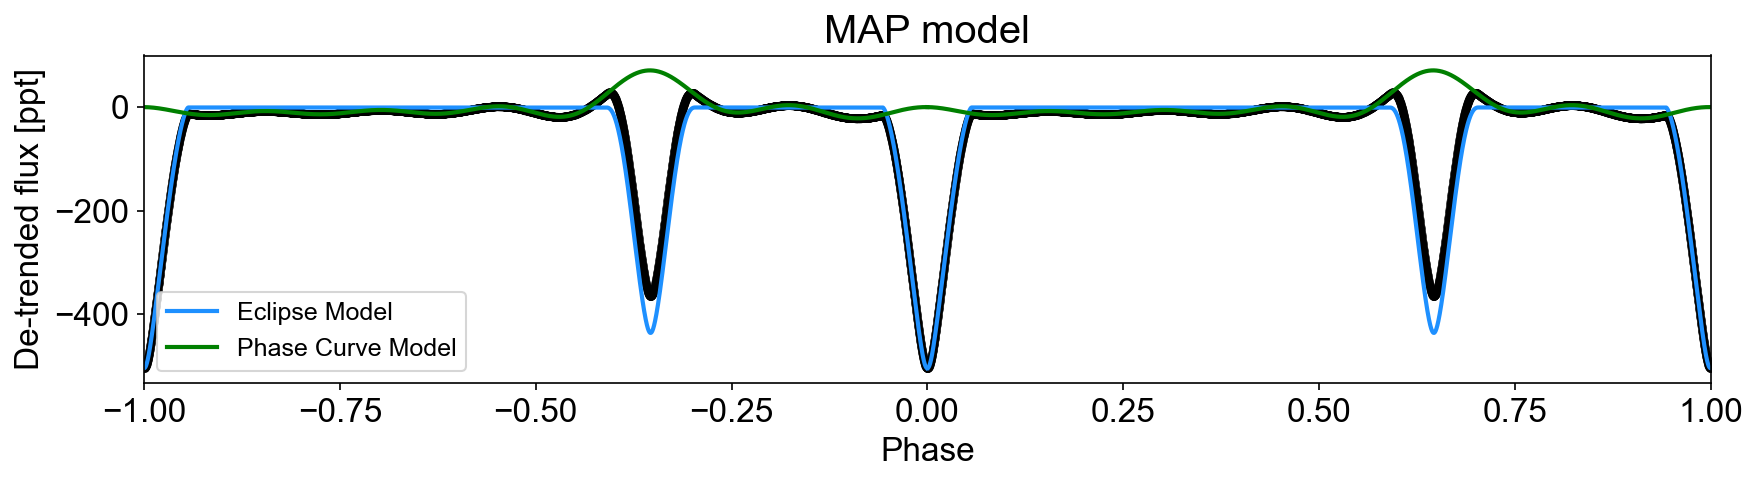

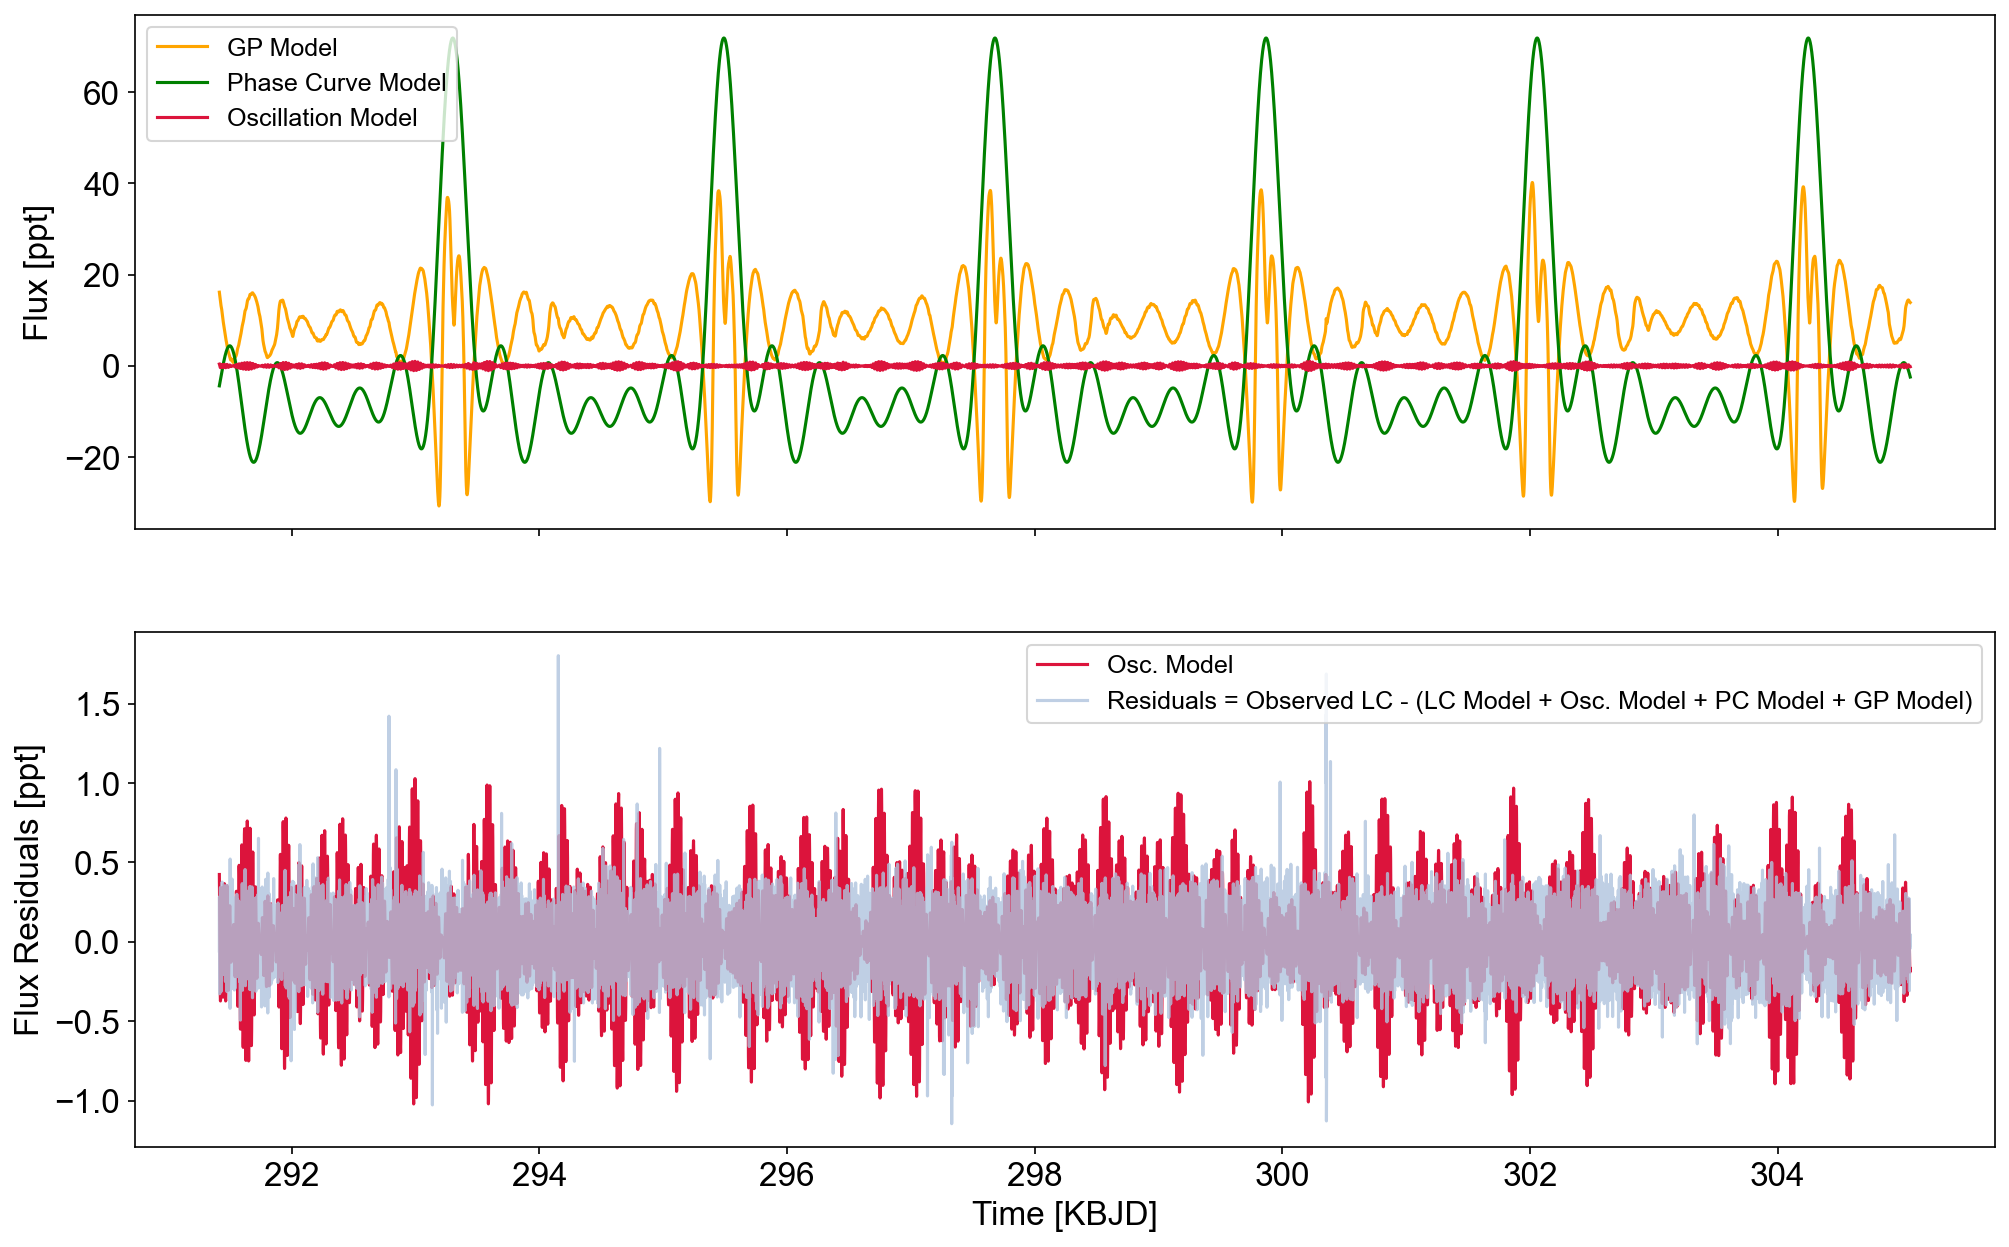

Found 5 frequencies
f = 47.05 1/d --> 0.0213 days, 0.51 hours, 30.61 min, 1836.48 sec
f = 48.43 1/d --> 0.0206 days, 0.50 hours, 29.73 min, 1783.99 sec
f = 47.52 1/d --> 0.0210 days, 0.51 hours, 30.30 min, 1818.11 sec
f = 45.22 1/d --> 0.0221 days, 0.53 hours, 31.85 min, 1910.75 sec
f = 46.09 1/d --> 0.0217 days, 0.52 hours, 31.24 min, 1874.68 sec


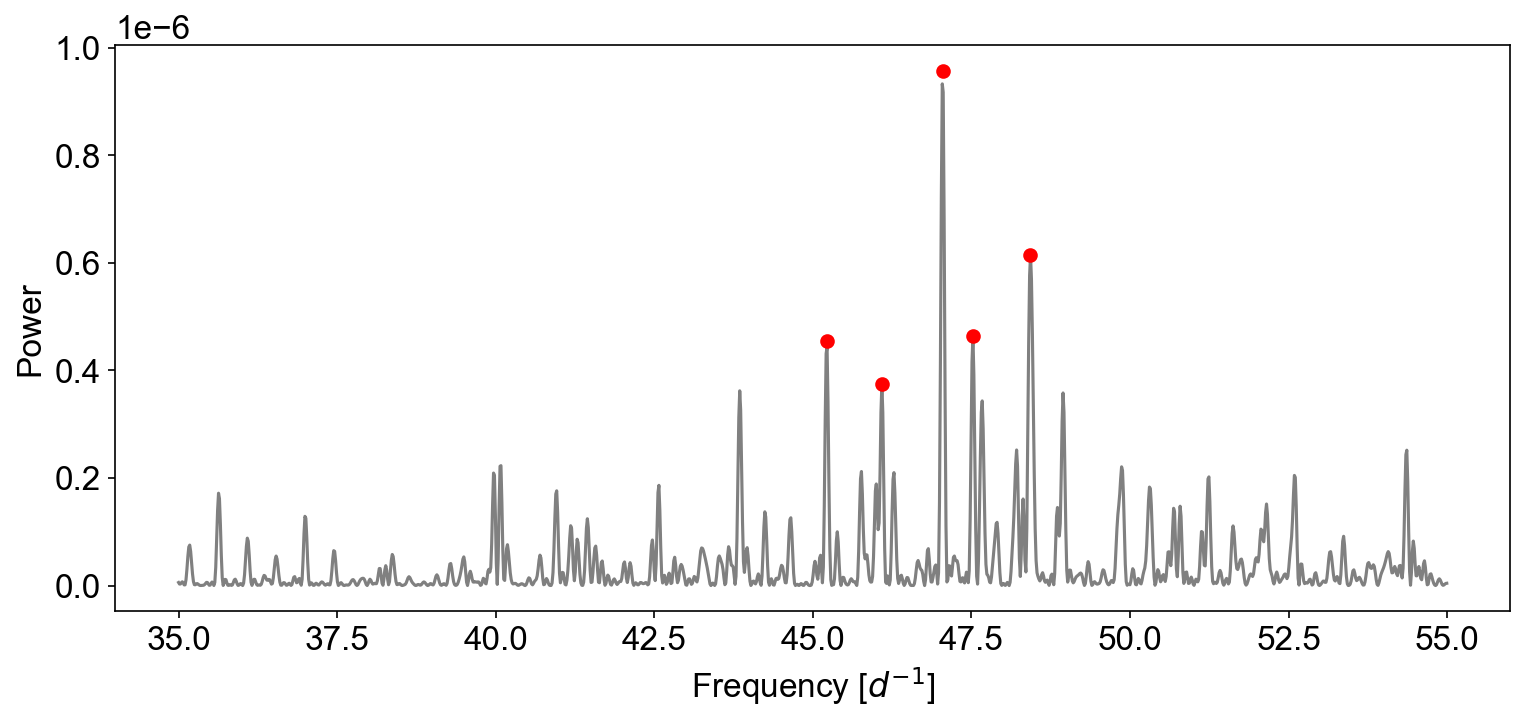

In [30]:
map_results = {} #store MAP model 
ls_results = {}

#Store MAP for the model components (to be improved: directly access them via best model)
osc_models = {} 
gp_models = {}
pc_models = {}
lc_models = {}

for iteration in range(0,5):  #just doing 5 iterations for simplicity
    print("\n               ITERATION %s\n--------------------------------------------" %iteration)
    if iteration == 0: 
        
        #mod_i, map_i = sigma_clip(x, y, freq_osc_0) 
        
        #Initialize the Model
        ls_results[iteration] = [freq_osc_0, power_osc_0] #initial freqs
        map_0 = {'sigma_lc': 1.0, 'S_tot_lc': 2.5, 'ell_lc': 2.0} #initial test_val
        mod_i, map_i = build_model(x, y, map_0, mask_iterative, freq_osc_0) 
        
        #Calculate model residuals & plot MAP
        residuals, best_osc, best_gp, best_pc, best_lc = evaluate_model(y, mod_i, map_i, str(iteration), plot_bool)
        
        #Run periodogram of the residuals
        _, freq_osc_i, power_osc_i = find_oscillations(x, residuals, 5,  35, 55, str(iteration))
       
    elif (iteration > 0) and (len(freq_osc)!=0): 
        #mod_i, map_i = sigma_clip(x, residuals, freq_osc)
        ls_results[iteration] = [freq_osc_i, power_osc_i]
        
        freq_osc_cumulative, _ = np.hstack([(freqs, powers) for (freqs,powers) in ls_results.values()])
        print("Accumulated frequencies:", len(freq_osc_cumulative))
        
        mod_i, map_i = build_model(x, y, map_i, mask_iterative, freq_osc_cumulative) 
        
        residuals, best_osc, best_gp, best_pc, best_lc = evaluate_model(y, mod_i, map_i, str(iteration), plot_bool)
        
        #Run periodogram of the residuals (todo: freq. grid based on expectations of model)
        _, freq_osc_i, power_osc_i = find_oscillations(x, residuals, 5,  35, 55, str(iteration))
        
    else: 
        #(I'll have find a better way to tell the code when to stop the iterations)
        print("The last periodogram does not show more significant frequencies.") 
        
    #Store the results
    map_results[iteration] = map_i
    osc_models[iteration] = best_osc
    gp_models[iteration] = best_gp
    pc_models[iteration] = best_pc
    lc_models[iteration] = best_lc
    
    

Plot best oscillation models 

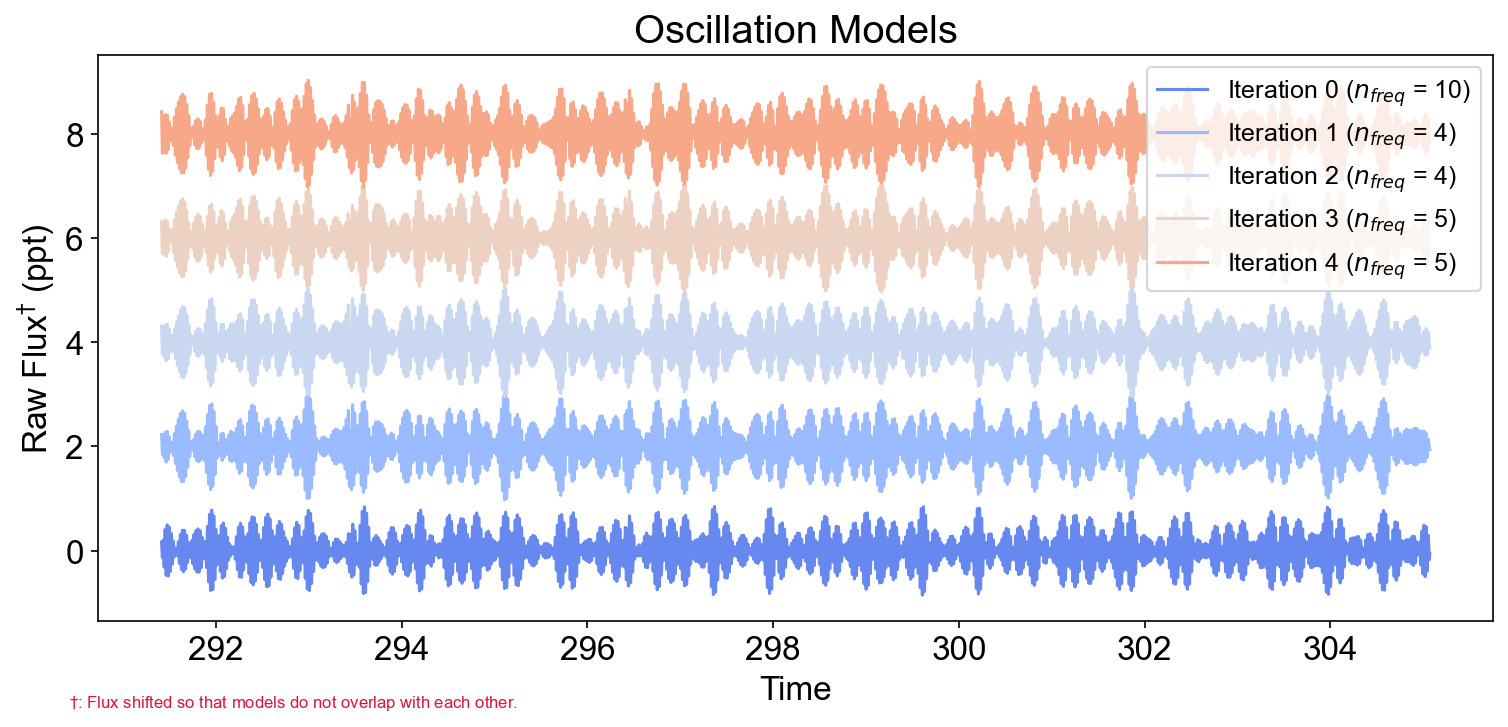

In [32]:
osc_palette = sns.color_palette("coolwarm");

fig, ax = plt.subplots(1,1)
y_shift = 0.0
for m in osc_models:
    nfreq=len(ls_results[m][0])
    ax.plot(x, osc_models[m]+y_shift, c=osc_palette[m], label = r"Iteration %s ($n_{freq}$ = %s)" %(m,nfreq))
    y_shift+=2.

ax.set(xlabel = "Time", ylabel = r"Raw Flux$^{\dagger}$ (ppt)", title="Oscillation Models");
ax.text(x.min()-1,-3,r"$\dagger$: Flux shifted so that models do not overlap with each other. ",c='crimson',fontsize=8)
plt.legend(fontsize=12)

In [ ]:
np.random.seed(4544587)
with model:
    trace = pm.sample(
        #tune=1000,
        #draws=1000,
        tune = 500,
        draws = 1000,
        start=map_soln,
        chains=2,
        target_accept=0.95,
    )

In [ ]:
pm.summary(trace)

In [ ]:
idata = az.from_pymc3(trace) 
idata.to_netcdf('results.nc')

In [ ]:
az.summary(idata)

In [ ]:
pm.model_graph.model_to_graphviz(model)

In [ ]:
pm.traceplot(trace);

In [ ]:
plt.plot(trace["a"])